In [1]:
# General
import pandas as pd
import numpy as np
from pandas import DataFrame
import datetime as dt
from functools import reduce

import sys
import os
from decimal import Decimal

# ML
import sklearn
import imblearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold, cross_val_score, StratifiedKFold # Stratified not currently required and unsure if I'll use gridsearch
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score, precision_score, average_precision_score, precision_recall_curve, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics # For some reason, the above were not loading in from this alone.
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import shap


# Visualisation
from plotly import tools
from plotly.subplots import make_subplots
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly as plotly
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact
import ipywidgets as widgets
from sklearn.inspection import PartialDependenceDisplay
#plt.style.use('seaborn')
import seaborn as sns
mpl.rcParams['font.family'] = 'serif'
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

# 1 - Import Data

In [3]:
# m_df = pd.read_csv('C:/Users/alexp/Desktop/DissCode/data_csv/m_df.csv')
# q_df = pd.read_csv('C:/Users/alexp/Desktop/DissCode/data_csv/q_df.csv')
q_df = pd.read_csv('C:/Users/alexp/Desktop/DissCode/data_csv/final_fred/q_full_data.csv')
m_df = pd.read_csv('C:/Users/alexp/Desktop/DissCode/data_csv/final_fred/m_full_data.csv')

# 2 - Clean Data

In [4]:
# convert to period
q_df['Date'] = pd.to_datetime(q_df['Date']).dt.to_period('M')

# set Date as index and resample
q_df = q_df.set_index('Date').resample('M').interpolate()

In [5]:
q_df.drop(q_df.tail(1).index,inplace=True)

In [6]:
m_df['Date'] = pd.to_datetime(m_df['Date']).dt.to_period('M')
m_df = m_df.set_index('Date')

In [7]:
# Concatenating dataframes
dfs = [q_df, m_df]
df = pd.concat(dfs, axis=1, join='outer')

In [8]:
df = df.reindex(sorted(df.columns), axis=1)

In [9]:
df = df.dropna()

## Differencing, Lags, and More

In [10]:
# Differencing
def log_diff(v):
    log_diff = np.log(v/v.shift(1))
    return log_diff

In [11]:
df_transform = df

In [12]:
# Is feature extraction required?

In [13]:
df_transform['usrecession'] = df['USREC'].shift(-1)
df_transform['spxbubble'] = df['spxbubble'].shift(-1) # shift -1 means that the target will focus on future and not past.
df_transform['A576RC1'] = log_diff(df['A576RC1'])
df_transform['AAA'] = df['AAA'].diff()
df_transform['AMDMNO'] = log_diff(df['AMDMNO'])
df_transform['AMDMUO'] = log_diff(df['AMDMUO'])
df_transform['AWHMAN'] = df['AWHMAN'].diff()
df_transform['BAA'] = df['BAA'].diff()
df_transform['BAAFFM'] = df['BAAFFM'].diff()
df_transform['BBKMLEIX'] = df['BBKMLEIX'].diff()
df_transform['BCNSDODNS'] = log_diff(df['BCNSDODNS'])
df_transform['BOGMBASE'] = log_diff(df['BOGMBASE'])
df_transform['BOGZ1FL594090005Q'] = log_diff(df['BOGZ1FL594090005Q'])
df_transform['BUSINVx'] = log_diff(df['BUSINVx'])
df_transform['BUSLOANS'] = log_diff(df['BUSLOANS'])
df_transform['CE16OV'] = log_diff(df['CE16OV'])
df_transform['CES0600000008'] = df['CES0600000008'].diff()
df_transform['CES2000000008'] = df['CES2000000008'].diff()
df_transform['CES3000000008'] = df['CES3000000008'].diff()
df_transform['CIVPART'] = df['CIVPART'].diff()
df_transform['CLAIMSx'] = log_diff(df['CLAIMSx'])
df_transform['CLF16OV'] = log_diff(df['CLF16OV'])
df_transform['CMRMTSPLx'] = log_diff(df['CMRMTSPLx'])
df_transform['COMPAPFFx'] = log_diff(df['COMPAPFFx'])
df_transform['CONSPI'] = df['CONSPI'].diff()
df_transform['CP'] = log_diff(df['CP'])
df_transform['CPIAUCSL'] = log_diff(df['CPIAUCSL'])
df_transform['CPILFESL'] = log_diff(df['CPILFESL']) # Causes -inf for some reason
df_transform['CUMFNS'] = df['CUMFNS'].diff()
df_transform['DDURRG3M086SBEA'] = df['DDURRG3M086SBEA'].diff() # Should data with index = 100 be .diff or log_diff?
df_transform['DSPIC96'] = log_diff(df['DSPIC96'])
df_transform['DTB3'] = df['DTB3'].diff()
df_transform['DTCOLNVHFNM'] = log_diff(df['DTCOLNVHFNM'])
df_transform['DTCTHFNM'] = log_diff(df['DTCTHFNM'])
df_transform['EXCAUSx'] = df['EXCAUSx'].diff()
df_transform['EXJPUSx'] = df['EXJPUSx'].diff()
df_transform['EXPGS'] = log_diff(df['EXPGS'])
df_transform['EXSZUSx'] = df['EXSZUSx'].diff()
df_transform['EXUSUKx'] = df['EXUSUKx'].diff()
df_transform['FEDFUNDS'] = df['FEDFUNDS'].diff()
df_transform['GS1'] = df['GS1'].diff()
df_transform['GS3'] = df['GS3'].diff()
df_transform['GS5'] = df['GS5'].diff()
df_transform['GS10'] = df['GS10'].diff()
df_transform['INDPRO'] = df['INDPRO'].diff() # index = 100...
df_transform['INVEST'] = df['INVEST'].diff()
df_transform['IRLTLT01USM156N'] = df['IRLTLT01USM156N'].diff()
df_transform['ISRATIOx'] = df['ISRATIOx'].diff()
df_transform['M1SL'] = log_diff(df['M1SL'])
df_transform['M2SL'] = log_diff(df['M2SL'])
df_transform['NONREVSL'] = log_diff(df['NONREVSL'])
df_transform['PAYEMS'] = log_diff(df['PAYEMS'])
df_transform['PCE'] = log_diff(df['PCE'])
df_transform['PERMIT'] = log_diff(df['PERMIT'])
df_transform['POPTHM'] = log_diff(df['POPTHM'])
df_transform['PPIACO'] = df['PPIACO'].diff()
df_transform['PSAVERT'] = df['PSAVERT'].diff()
df_transform['REALLN'] = log_diff(df['REALLN'])
df_transform['RPI'] = log_diff(df['RPI'])
df_transform['spx'] = log_diff(df['spx'])
df_transform['spx_div_yield'] = df['spx_div_yield'].diff()
df_transform['spx_e'] = log_diff(df['spx_e'])
df_transform['spx_pd'] = df['spx_pd'].diff()
df_transform['spx_pe'] = log_diff(df['spx_pe'])
df_transform['T10YFFM'] = df['T10YFFM'].diff()
df_transform['T1YFFM'] = df['T10YFFM'].diff()
df_transform['T5YFFM'] = df['T5YFFM'].diff()
df_transform['TB3MS'] = df['TB3MS'].diff()
df_transform['TB3SMFFM'] = df['TB3SMFFM'].diff()
df_transform['TB6MS'] = df['TB6MS'].diff()
df_transform['TB6SMFFM'] = df['TB6SMFFM'].diff()
df_transform['TOTRESNS'] = log_diff(df['TOTRESNS'])
df_transform['UNRATE'] = df['UNRATE'].diff()
df_transform['WPSFD49207'] = df['WPSFD49207'].diff() # INDEX=100
df_transform['WTISPLC'] = log_diff(df['WTISPLC'])

## Defining a Crash

In [14]:
# Using drawdown over a given month we can determine historical 'crash' dates and create dummy variables

In [15]:
def drawdown(return_series: pd.Series):
    """
Takes a time series of asset returns.
returns a DataFrame with columns for
the wealth index, the previous peaks, 
and the percentage drawdown
    """
    wealth_index = 1000000000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks*100
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [16]:
m_df.head()

,USREC,spxbubble,A576RC1,AAA,AMDMNO,AMDMUO,AWHMAN,BAA,BAAFFM,BBKMLEIX,...,T1YFFM,T5YFFM,TB3MS,TB3SMFFM,TB6MS,TB6SMFFM,TOTRESNS,UNRATE,WPSFD49207,WTISPLC
Date,,,,,,,,,,,,,,,,,,,,,
1960-01,0,0,270.1,4.61,14584.80867,44858.90398,40.6,5.34,1.35,0.330325,...,1.04,0.93,4.35,0.36,4.74,0.75,18.8,5.2,33.1,2.97
1960-02,0,0,270.8,4.56,14535.90107,43828.80497,40.3,5.34,1.37,0.693720,...,0.69,0.72,3.96,-0.01,4.30,0.33,18.2,4.8,33.1,2.97
1960-03,0,0,271.3,4.49,14375.07033,42848.30333,40.0,5.25,1.41,0.949791,...,0.18,0.47,3.31,-0.53,3.61,-0.23,18.0,5.4,33.4,2.97
1960-04,0,0,273.0,4.45,14220.82331,42054.74558,40.0,5.20,1.28,1.337583,...,0.12,0.37,3.23,-0.69,3.55,-0.37,18.1,5.2,33.4,2.97
1960-05,1,0,273.7,4.46,14392.94042,41591.20103,40.1,5.28,1.43,0.893631,...,0.36,0.64,3.29,-0.56,3.58,-0.27,18.2,5.1,33.4,2.97


In [17]:
df2 = m_df[['USREC', 'spx', 'spxbubble']]

In [18]:
df2.head()

,USREC,spx,spxbubble
Date,,,
1960-01,0,55.61,0
1960-02,0,56.12,0
1960-03,0,55.34,0
1960-04,0,54.37,0
1960-05,1,55.83,0


In [19]:
spx_rets = df2[['USREC', 'spx', 'spxbubble']]

In [20]:
spx_rets = spx_rets.dropna()

In [21]:
spx_rets['spx_rets'] = spx_rets['spx'].pct_change(1)

In [22]:
crash_recs = spx_rets.query('USREC==1')
crash_bubble = spx_rets.query('spxbubble==1')

In [23]:
crash_recs = crash_recs.drop(columns=['spx', 'spx_rets'])

In [24]:
spx_rets2 = spx_rets[['spx_rets']]

In [25]:
drawdown = drawdown(spx_rets2['spx_rets'])[['Drawdown']]

In [26]:
drawdown = drawdown.dropna()

In [27]:
drawdown.head()

,Drawdown
Date,
1960-02,0.000000
1960-03,-1.389879
1960-04,-3.118318
1960-05,-0.516750
1960-06,0.000000


In [28]:
spx_rets['Drawdown'] = drawdown.abs()

In [29]:
spx_rets['USREC'] = spx_rets['USREC'] * 100 

In [30]:
spx_rets['spxbubble'] = spx_rets['spxbubble'] * 100

In [31]:
spx_rets.head()

,USREC,spx,spxbubble,spx_rets,Drawdown
Date,,,,,
1960-01,0,55.61,0,NaN,NaN
1960-02,0,56.12,0,0.009171,0.000000
1960-03,0,55.34,0,-0.013899,1.389879
1960-04,0,54.37,0,-0.017528,3.118318
1960-05,100,55.83,0,0.026853,0.516750


(60.0, 0.0)

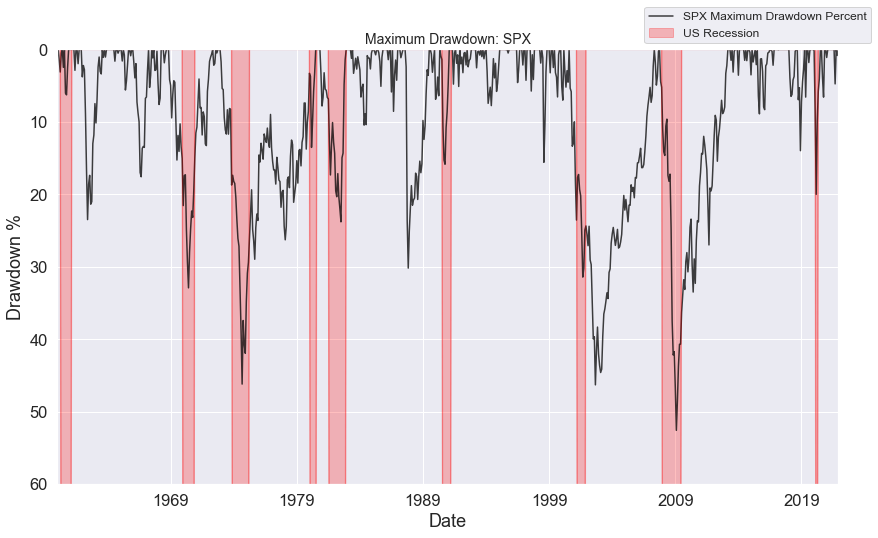

In [32]:
fig, ax = plt.subplots()
spx_rets['Drawdown'].plot.line(figsize=(16, 8), alpha=0.75, color="black", label='SPX Maximum Drawdown Percent')
spx_rets['USREC'].plot.area(figsize=(14, 8), alpha=0.25, color="red", label = 'US Recession')
plt.ylabel('Drawdown %')
plt.title('Maximum Drawdown: SPX', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(60, 0)

(60.0, 0.0)

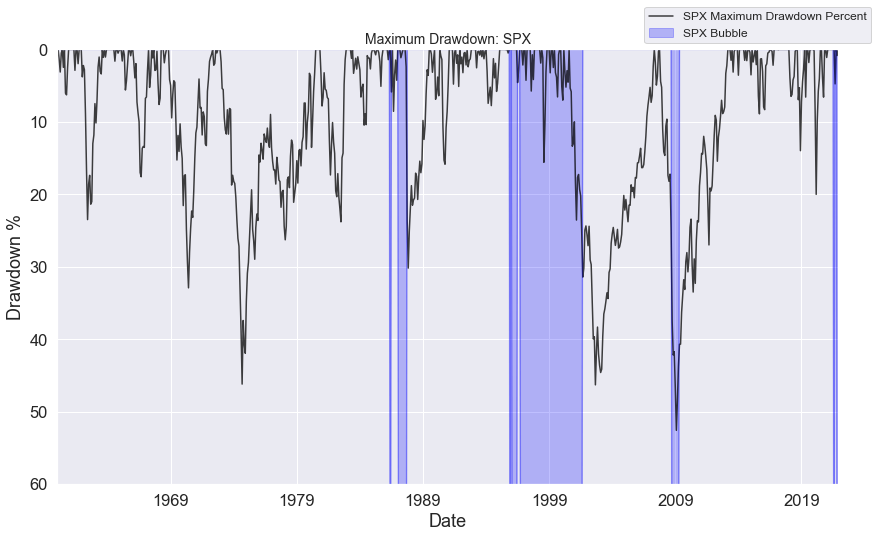

In [33]:
fig, ax = plt.subplots()
spx_rets['Drawdown'].plot.line(figsize=(16, 8), alpha=0.75, color="black", label='SPX Maximum Drawdown Percent')
spx_rets['spxbubble'].plot.area(figsize=(14, 8), alpha=0.25, color="blue", label = 'SPX Bubble')
plt.ylabel('Drawdown %')
plt.title('Maximum Drawdown: SPX', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(60, 0)

(60.0, 0.0)

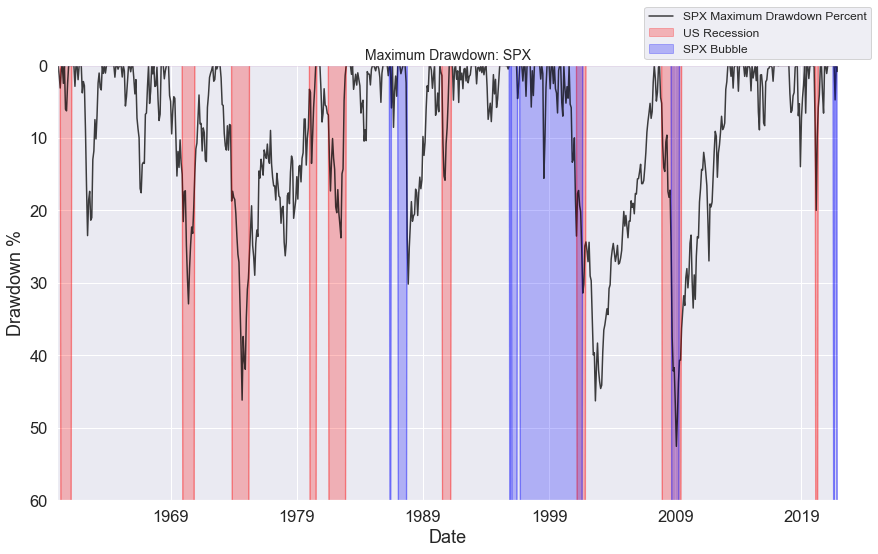

In [34]:
fig, ax = plt.subplots()
spx_rets['Drawdown'].plot.line(figsize=(16, 8), alpha=0.75, color="black", label='SPX Maximum Drawdown Percent')
spx_rets['USREC'].plot.area(figsize=(14, 8), alpha=0.25, color="red", label = 'US Recession')
spx_rets['spxbubble'].plot.area(figsize=(14, 8), alpha=0.25, color="blue", label = 'SPX Bubble')
plt.ylabel('Drawdown %')
plt.title('Maximum Drawdown: SPX', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(60, 0)

In [35]:
m_df.shape

(744, 74)

In [36]:
m_df.query('USREC==0').shape

(649, 74)

In [37]:
m_df.query('USREC==1').shape

(95, 74)

In [38]:
m_df.query('spxbubble==0').shape

(660, 74)

In [39]:
m_df.query('spxbubble==1').shape

(84, 74)

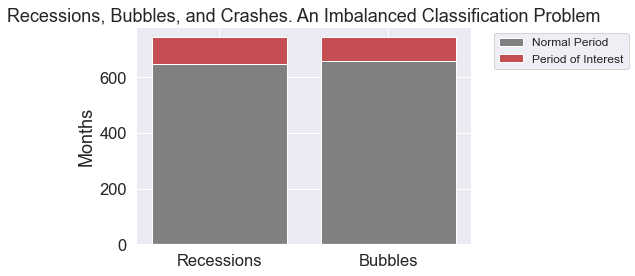

In [40]:
x_axis = ['Recessions', 'Bubbles']
y1 = [649, 660]
y2 = [95, 84]
plt.bar(x_axis, y1, color='grey', label='Normal Period')
plt.bar(x_axis, y2, bottom=y1, color='r', label='Period of Interest')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=0)
plt.title('Recessions, Bubbles, and Crashes. An Imbalanced Classification Problem')
plt.ylabel('Months')
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

In [41]:
# df_transform = df_transform.fillna(0); Could be dangerous as it imputes potentially false values into spxbubble and usrec
df_transform = df_transform.dropna()

In [42]:
y_rec = df_transform['usrecession']
y_b = df_transform['spxbubble']
X = df_transform.drop(['CPILFESL', 'USREC', 'spxbubble', 'usrecession'], axis=1)

In [43]:
# divide in train test - Whilst aiming for the same 80/20 split as Yazdani, the test dataset would miss out having the 2006-2008 turbulent period, which would prove to be a great test
# for the model. Therefore, I have altered the dataset slightly so  that the test set is slightly larger.
# Alternative to shuffle=False on train_test_split and helps select specific dates.
X_train, y_rec_train = (X.iloc[0:550], y_rec.iloc[0:550])
X_test, y_rec_test = (X.iloc[550:], y_rec.iloc[550:])
X_train, y_b_train = (X.iloc[0:550], y_b.iloc[0:550])
X_test, y_b_test = (X.iloc[550:], y_b.iloc[550:])

In [44]:
# Checking for infinite (or -inf) values
X.isin([np.inf, -np.inf])
  
count = np.isinf(X).values.sum()
print("It contains " + str(count) + " infinite values")
  
print()
col_name = X.columns.to_series()[np.isinf(X).any()]
print(col_name)
  
print()
  
r = X.index[np.isinf(X).any(1)]
print(r)

It contains 0 infinite values

Series([], dtype: object)

PeriodIndex([], dtype='period[M]', name='Date')


In [45]:
sm = SMOTE(random_state=1)

In [46]:
# Smote for bubbles:
b_sm = SMOTE(random_state=2)

In [47]:
np.bincount(y_rec) # A clear class imbalance

array([646,  95], dtype=int64)

Text(0, 0.5, 'Number of Bubbles')

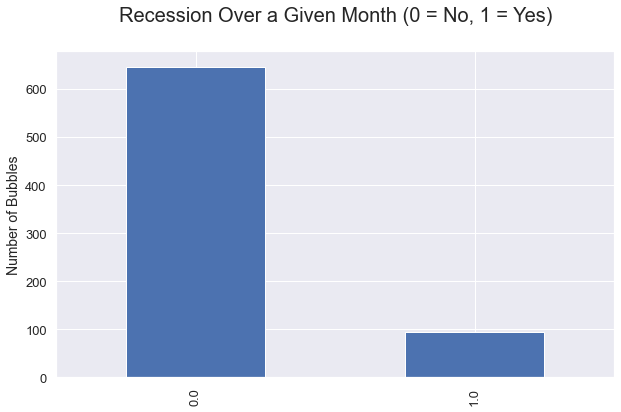

In [48]:
ax = y_rec.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13)
ax.set_title('Recession Over a Given Month (0 = No, 1 = Yes)', size=20, pad=30)
ax.set_ylabel('Number of Bubbles', fontsize=14)

## Time Series Cross Validation

In [49]:
# Do I need to df.sort_index() prior to this?

In [50]:
# SMOTE will be applied to each split via implementing SMOTE into the imbpipeline in each model.

In [51]:
tscv = TimeSeriesSplit(n_splits=5)

fold = 1

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y_rec.iloc[train_index], y_rec.iloc[test_index]
    print('Split %d.' % fold, 'Training set observations: %d,' % len(train_index), 'Testing set observations: %d' % len(test_index))
    fold += 1

Split 1. Training set observations: 126, Testing set observations: 123
Split 2. Training set observations: 249, Testing set observations: 123
Split 3. Training set observations: 372, Testing set observations: 123
Split 4. Training set observations: 495, Testing set observations: 123
Split 5. Training set observations: 618, Testing set observations: 123


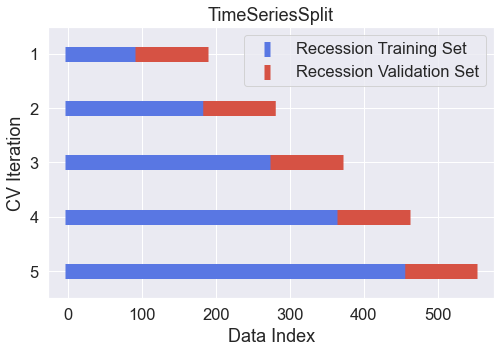

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))

for ii, (tr, tt) in enumerate(tscv.split(X_train, y_rec_train)):
    l1 = ax.scatter(tr, [ii+1] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=15)
    l2 = ax.scatter(tt, [ii+1] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=15)
    ax.set(ylim=[5.5, 0.5], title='TimeSeriesSplit', xlabel='Data Index', ylabel='CV Iteration')
    ax.legend([l1, l2], ['Recession Training Set', 'Recession Validation Set'], loc=0)
    sns.set_style("darkgrid")

## LogisticRegression

In [53]:
logit = LogisticRegression(random_state=1)
logit.fit(X_train, y_rec_train)
print("Logistic Regression Accuracy: {:.2f}%".format(logit.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, logit.predict(X_test)))

Logistic Regression Accuracy: 33.51%
              precision    recall  f1-score   support

         0.0       0.98      0.26      0.41       171
         1.0       0.13      0.95      0.23        20

    accuracy                           0.34       191
   macro avg       0.55      0.61      0.32       191
weighted avg       0.89      0.34      0.40       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

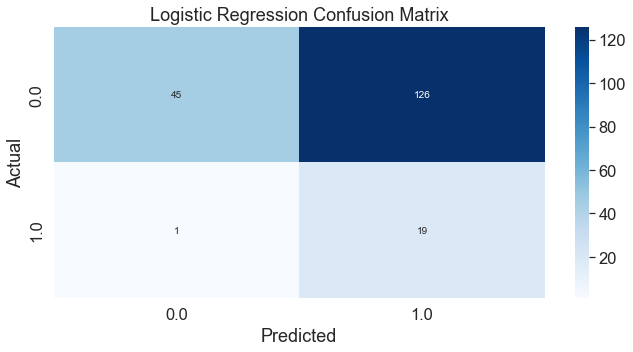

In [54]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, logit.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Logistic Regression Confusion Matrix')

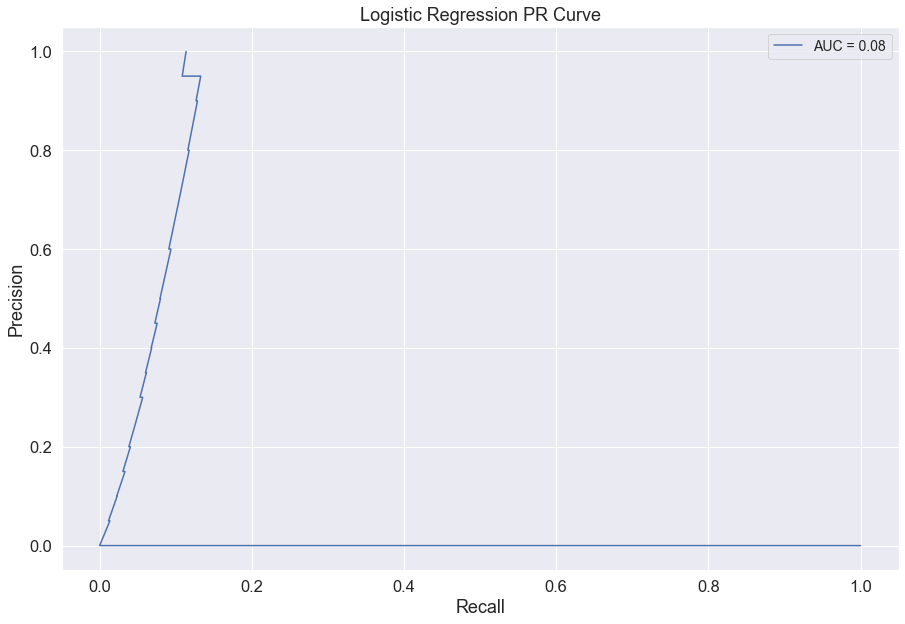

In [55]:
logit_pr_auc = average_precision_score(y_rec_test, logit.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, logit.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % logit_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression PR Curve')
plt.legend(fontsize=14, loc=0)
plt.show()

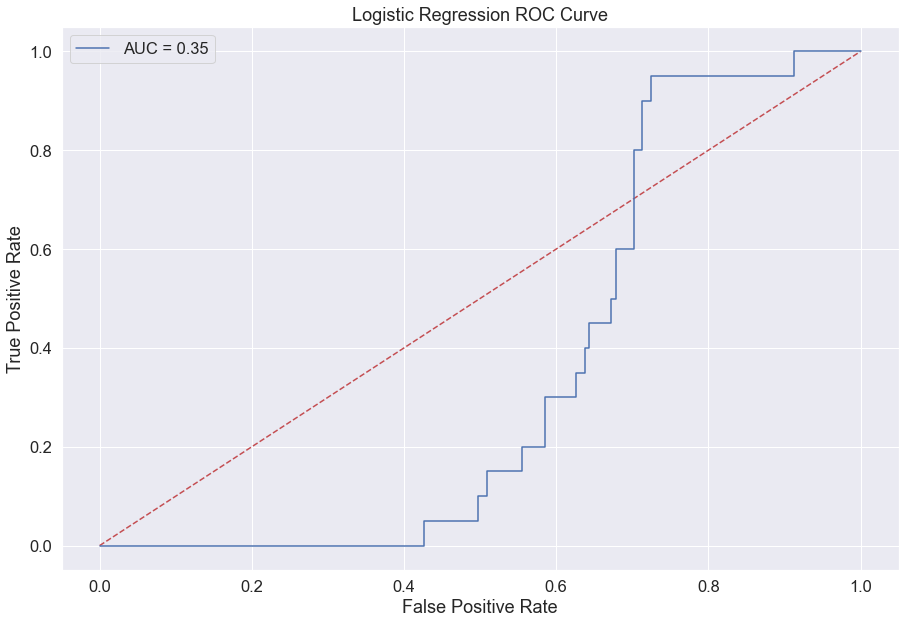

In [56]:
logit_roc_auc = roc_auc_score(y_rec_test, logit.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_rec_test, logit.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logit_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc=0)
plt.show()

### Tuned LogisticRegression

In [57]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('classifier', LogisticRegression())]) # Should imbalance fixing come before StandardScaler? - smote first slightly improved precision and recall here but unsure why.

cspace = np.logspace(-5, 2, 50)

param_grid = {'classifier__C': cspace, 'classifier__penalty': ['l1', 'l2']}

logit_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

logit_cv.fit(X_train, y_rec_train)

print("Tuned Logistic Regression Parameters: {}".format(logit_cv.best_params_)) 
print("Tuned Logistic Regression Accuracy: {:.2f}%".format(logit_cv.best_score_*100))
print(classification_report(y_rec_test, logit_cv.predict(X_test)))

Tuned Logistic Regression Parameters: {'classifier__C': 0.026826957952797246, 'classifier__penalty': 'l2'}
Tuned Logistic Regression Accuracy: 81.10%
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       171
         1.0       0.93      0.65      0.76        20

    accuracy                           0.96       191
   macro avg       0.94      0.82      0.87       191
weighted avg       0.96      0.96      0.95       191



In [58]:
# A good start

Text(0.5, 1.0, 'Tuned Logistic Regression Confusion Matrix')

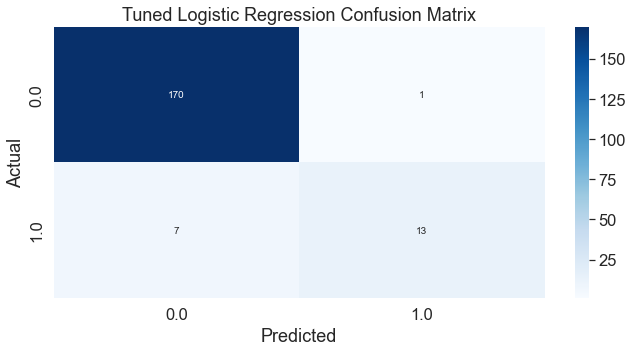

In [59]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, logit_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Logistic Regression Confusion Matrix')

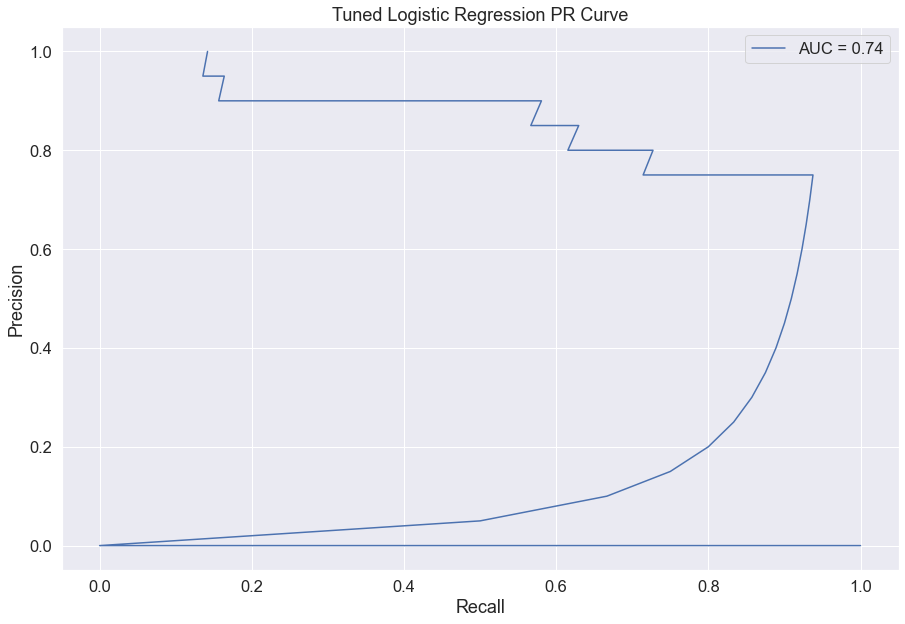

In [60]:
logit_pr_auc = average_precision_score(y_rec_test, logit_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, logit_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % logit_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Logistic Regression PR Curve')
plt.legend(loc=0)
plt.show()

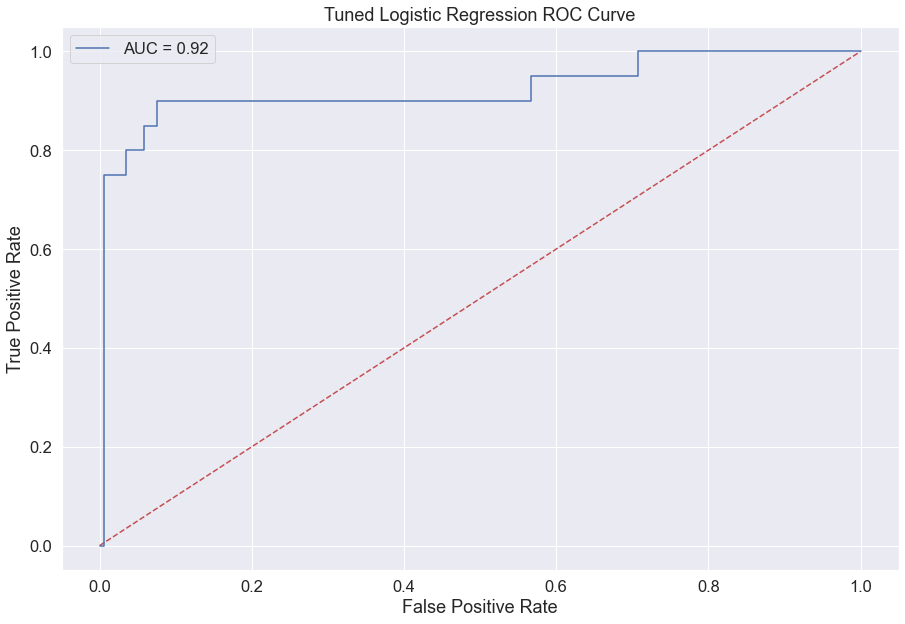

In [61]:
y_rec_predict_prob = logit_cv.predict_proba(X_test)[:,1]

logit_roc_auc = roc_auc_score(y_rec_test, y_rec_predict_prob)
fpr, tpr, thresholds = roc_curve(y_rec_test, y_rec_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logit_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Logistic Regression ROC Curve')
plt.legend(loc=0)
plt.show()

## Decision Tree Classifier

In [62]:
tree = DecisionTreeClassifier(random_state=1)

tree.fit(X_train, y_rec_train)

treepredict = tree.predict(X_test)

print("Decision Tree Accuracy: {:.2f}%".format(tree.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, treepredict))

Decision Tree Accuracy: 90.05%
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       171
         1.0       0.53      0.50      0.51        20

    accuracy                           0.90       191
   macro avg       0.73      0.72      0.73       191
weighted avg       0.90      0.90      0.90       191



In [63]:
# Reasonable scores

Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix')

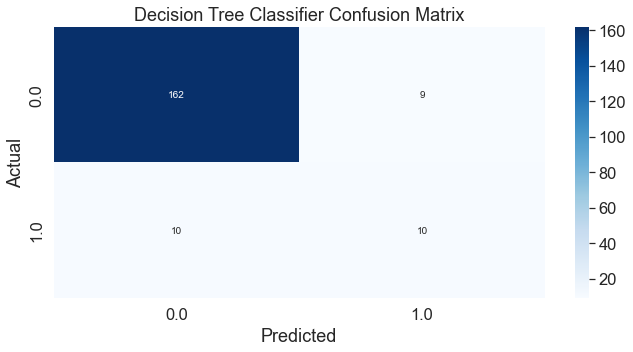

In [64]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, treepredict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Decision Tree Classifier Confusion Matrix')

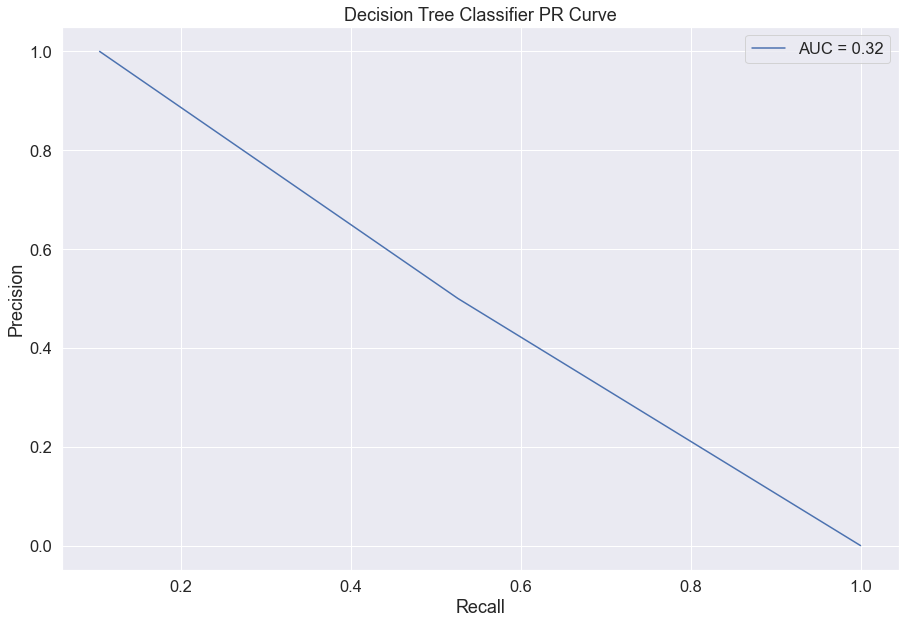

In [65]:
tree_pr_auc = average_precision_score(y_rec_test, tree.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, tree.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tree_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Classifier PR Curve')
plt.legend(loc=0)
plt.show()

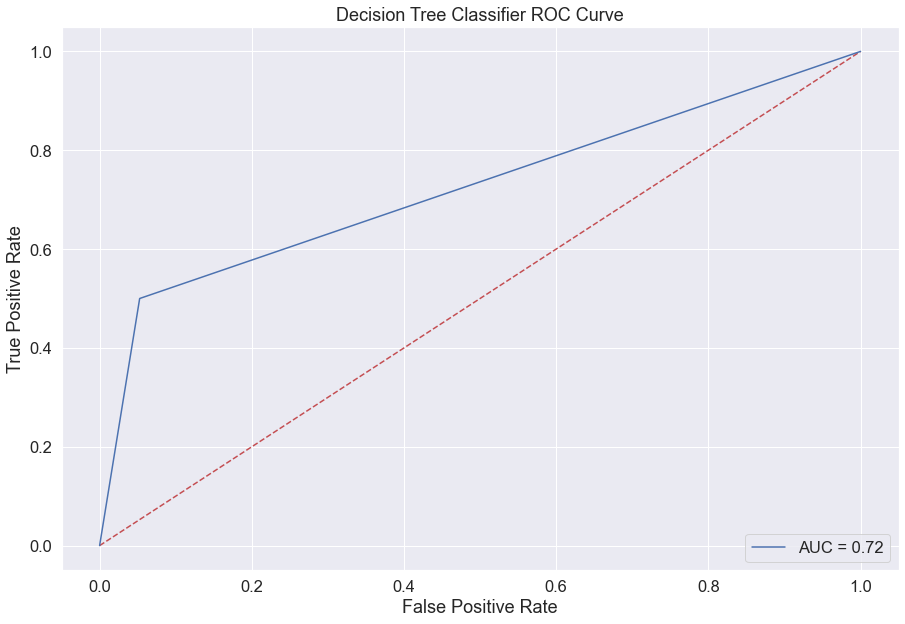

In [66]:
y_rec_predict_prob = tree.predict_proba(X_test)[:,1]

tree_roc_auc = roc_auc_score(y_rec_test, y_rec_predict_prob)
fpr, tpr, thresholds = roc_curve(y_rec_test, y_rec_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tree_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curve')
plt.legend(loc=4)
plt.show()

### Tuned Decision Tree Classifier

In [67]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('tree', tree)])

param_dist = {"tree__max_depth": [1],
              "tree__max_features": range(1, 10),
              "tree__min_samples_leaf": range(1, 10), 
              "tree__criterion": ["gini", "entropy"]}


tree_cv = GridSearchCV(pipeline, param_grid=param_dist, cv=tscv, n_jobs=-1)

tree_cv.fit(X_train, y_rec_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Tuned Decision Tree Accuracy: {:.2f}%".format(tree_cv.best_score_*100))
print(classification_report(y_rec_test, tree_cv.predict(X_test)))

Tuned Decision Tree Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__max_features': 1, 'tree__min_samples_leaf': 1}
Tuned Decision Tree Accuracy: 74.73%
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84       171
         1.0       0.27      0.85      0.41        20

    accuracy                           0.74       191
   macro avg       0.62      0.79      0.62       191
weighted avg       0.90      0.74      0.79       191



In [68]:
# Improved recall but much worse precision.

Text(0.5, 1.0, 'Tuned Decision Tree Classifier Confusion Matrix')

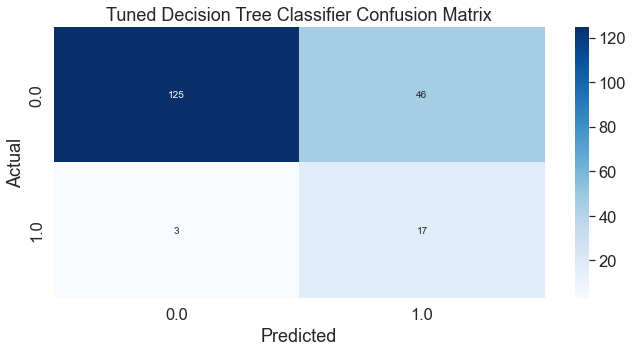

In [69]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, tree_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Decision Tree Classifier Confusion Matrix')

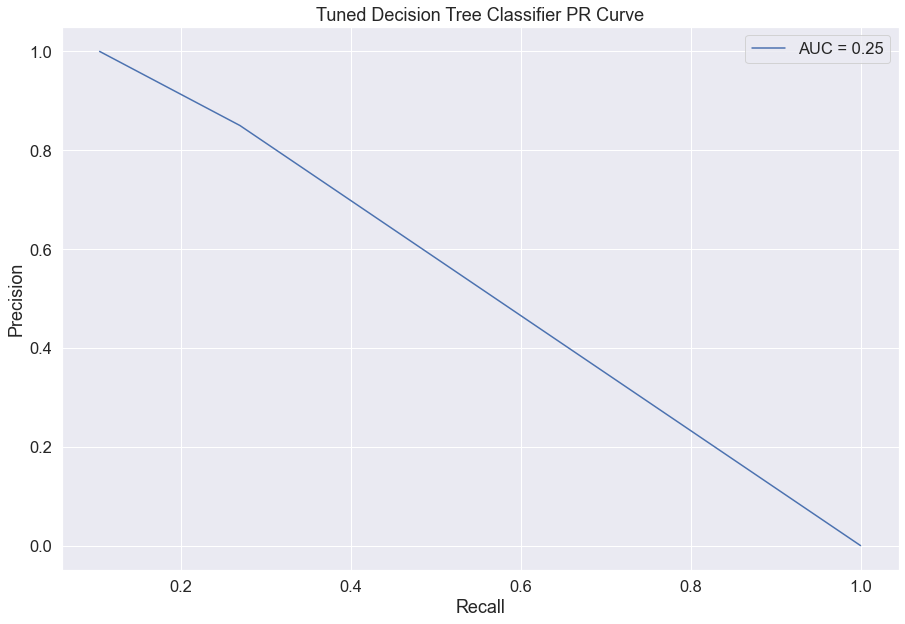

In [70]:
tuned_tree_pr_auc = average_precision_score(y_rec_test, tree_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, tree_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_tree_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Decision Tree Classifier PR Curve')
plt.legend(loc=0)
plt.show()

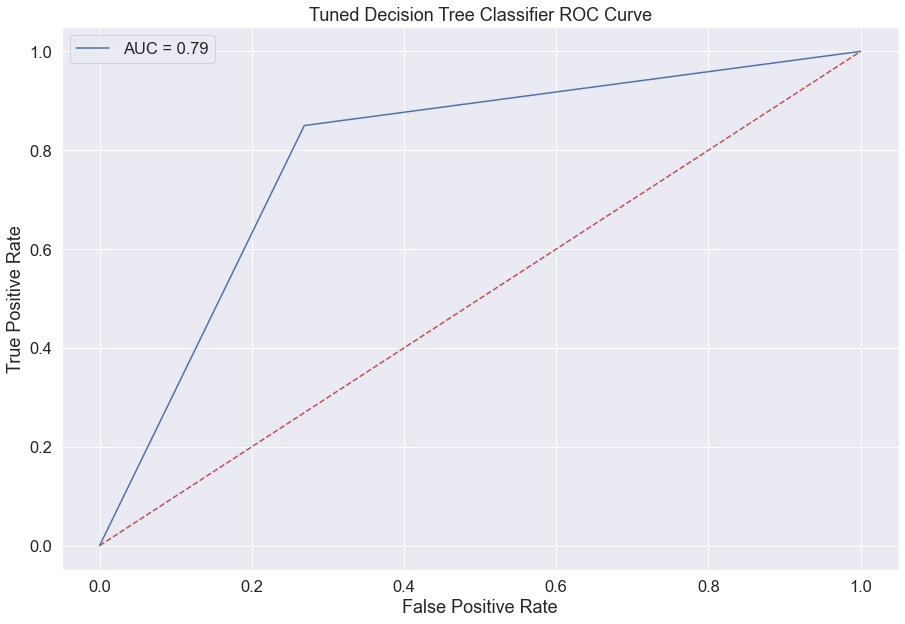

In [71]:
y_rec_predict_prob = tree_cv.predict_proba(X_test)[:,1]

tuned_tree_roc_auc = roc_auc_score(y_rec_test, y_rec_predict_prob)
fpr, tpr, thresholds = roc_curve(y_rec_test, y_rec_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_tree_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Decision Tree Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

## Support Vector Classification

In [72]:
svc = SVC(probability=True, random_state=1)

svc.fit(X_train, y_rec_train)

svc_predict = svc.predict(X_test)

print("Unscaled Support Vector Classifier Accuracy: {:.2f}%".format(svc.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, svc_predict))

Unscaled Support Vector Classifier Accuracy: 89.53%
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       171
         1.0       0.00      0.00      0.00        20

    accuracy                           0.90       191
   macro avg       0.45      0.50      0.47       191
weighted avg       0.80      0.90      0.85       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'Support Vector Classifier Confusion Matrix')

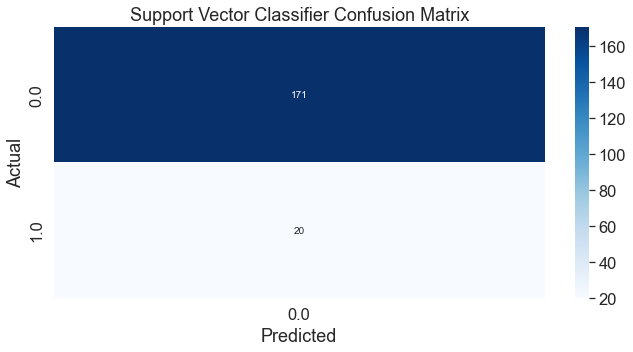

In [73]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, svc_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Support Vector Classifier Confusion Matrix')

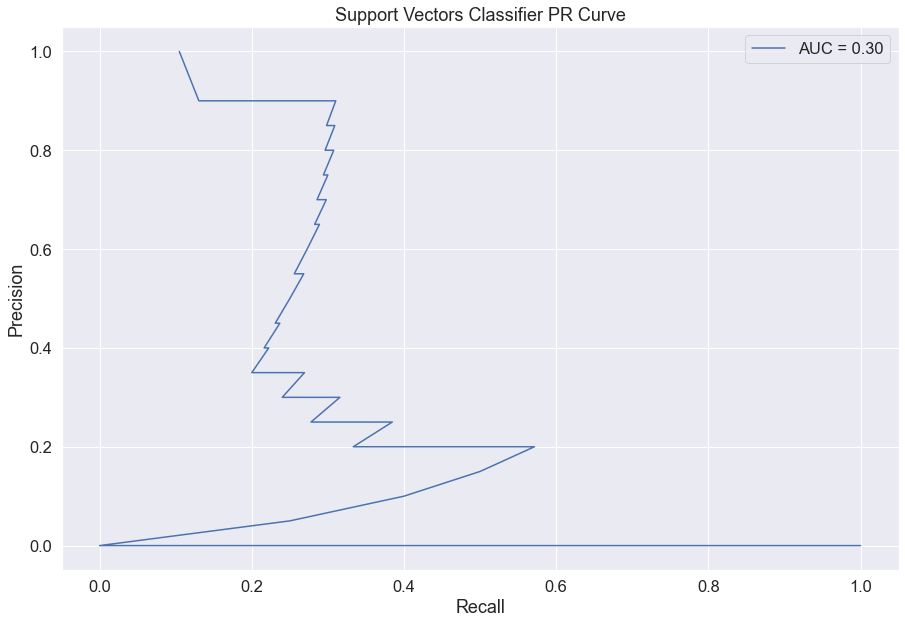

In [74]:
svc_pr_auc = average_precision_score(y_rec_test, svc.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, svc.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % svc_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Support Vectors Classifier PR Curve')
plt.legend(loc=0)
plt.show()

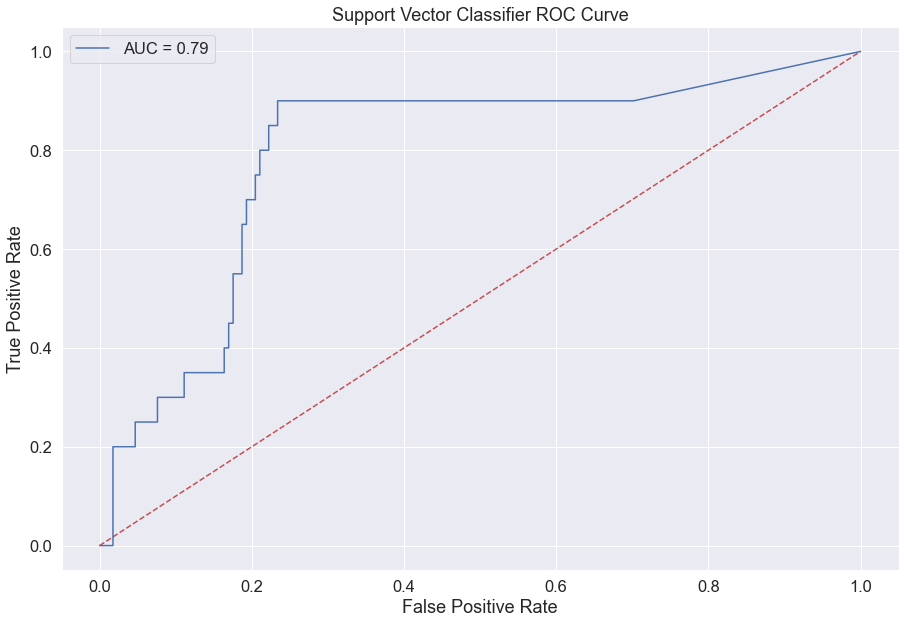

In [75]:
svc_roc_auc = roc_auc_score(y_rec_test, svc.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_rec_test, svc.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % svc_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

In [76]:
# Still scored well on ROC because majority class is no recession. This shows that ROC is a poor metric for performance when dealing with imbalanced sets.

### Tuned SVM with Radial Basis Function

In [77]:
# SVM requires StandardScaler on training set because the features with the largest range will completely dominate if not scaled
# Does this mean I have to apply StandardScaler to other models even though they may not require it?

In [78]:
steps = [('sm', sm), ('scaler', StandardScaler()),
        ('SVC', SVC(probability=True, random_state=1))]

c_space = np.logspace(-5, 2, 50)
param_dist = {'SVC__C': c_space, 'SVC__kernel': ['linear', 'rbf'], 'SVC__gamma': ['scale', 'auto']}

pipeline = Pipeline(steps)

svc_cv = GridSearchCV(pipeline, param_grid=param_dist, cv=tscv, n_jobs=-1)

svc_cv.fit(X_train, y_rec_train)

print("Tuned Support Vector Classifier with Scaled Parameters: {}".format(svc_cv.best_params_)) 
print('Tuned Support Vector Classifier with Scaled Accuracy: {:.2f}%'.format(svc_cv.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, svc_cv.predict(X_test)))

Tuned Support Vector Classifier with Scaled Parameters: {'SVC__C': 0.0001, 'SVC__gamma': 'scale', 'SVC__kernel': 'linear'}
Tuned Support Vector Classifier with Scaled Accuracy: 94.24%
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       171
         1.0       0.91      0.50      0.65        20

    accuracy                           0.94       191
   macro avg       0.93      0.75      0.81       191
weighted avg       0.94      0.94      0.93       191



Text(0.5, 1.0, 'Tuned Support Vector Classifier Confusion Matrix')

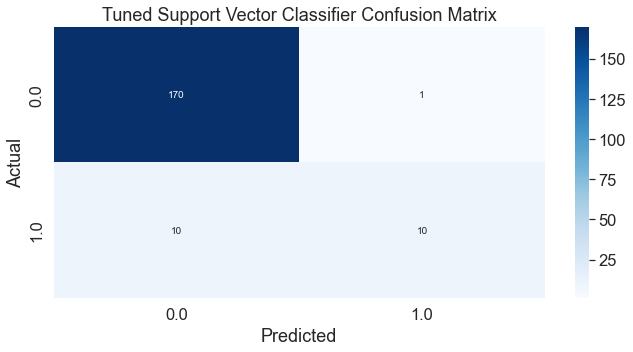

In [79]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, svc_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Support Vector Classifier Confusion Matrix')

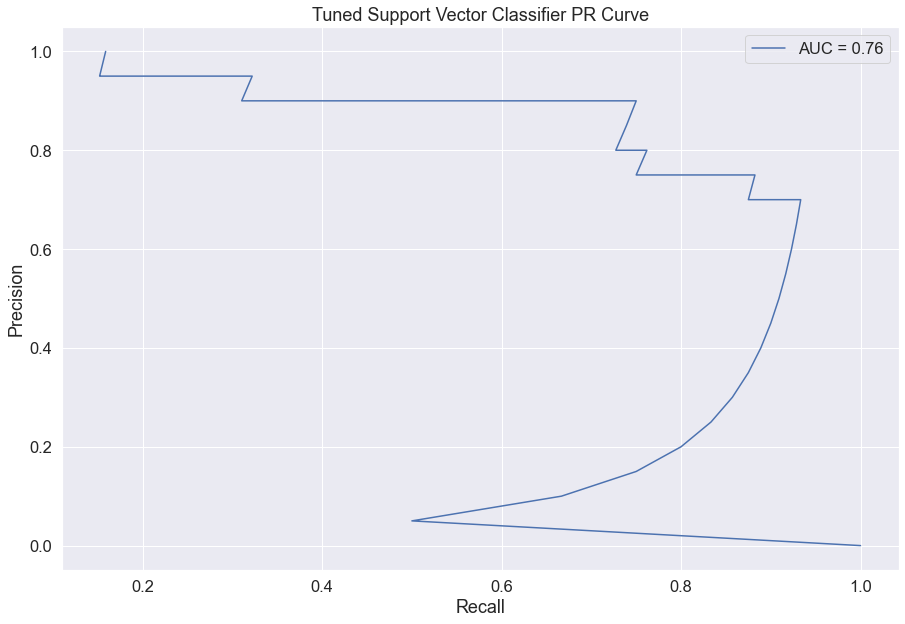

In [80]:
tuned_svc_pr_auc = average_precision_score(y_rec_test, svc_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, svc_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_svc_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Support Vector Classifier PR Curve')
plt.legend(loc=0)
plt.show()

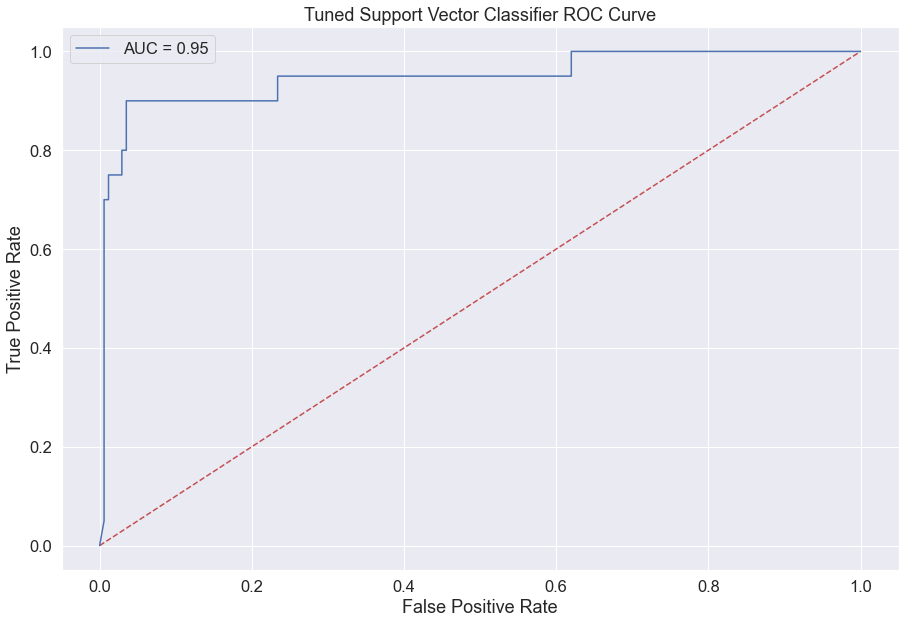

In [81]:
y_rec_predict_prob = svc_cv.predict_proba(X_test)[:,1]

tuned_svc_roc_auc = roc_auc_score(y_rec_test, y_rec_predict_prob)
fpr, tpr, thresholds = roc_curve(y_rec_test, y_rec_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_svc_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Support Vector Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

## RandomForest Classification

In [82]:
# RF commonly performs best in the literature. Expecting strong results

In [83]:
rf = RandomForestClassifier(random_state=1)

rf.fit(X_train, y_rec_train)

rf_predict = rf.predict(X_test)

print("Decision Tree Accuracy: {:.2f}%".format(rf.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, rf_predict))

Decision Tree Accuracy: 92.15%
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       171
         1.0       0.86      0.30      0.44        20

    accuracy                           0.92       191
   macro avg       0.89      0.65      0.70       191
weighted avg       0.92      0.92      0.90       191



In [84]:
# Poor recall.

Text(0.5, 1.0, 'RandomForest Classifier Confusion Matrix')

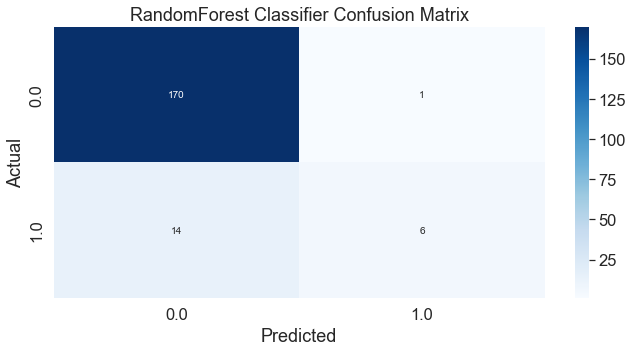

In [85]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, rf_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('RandomForest Classifier Confusion Matrix')

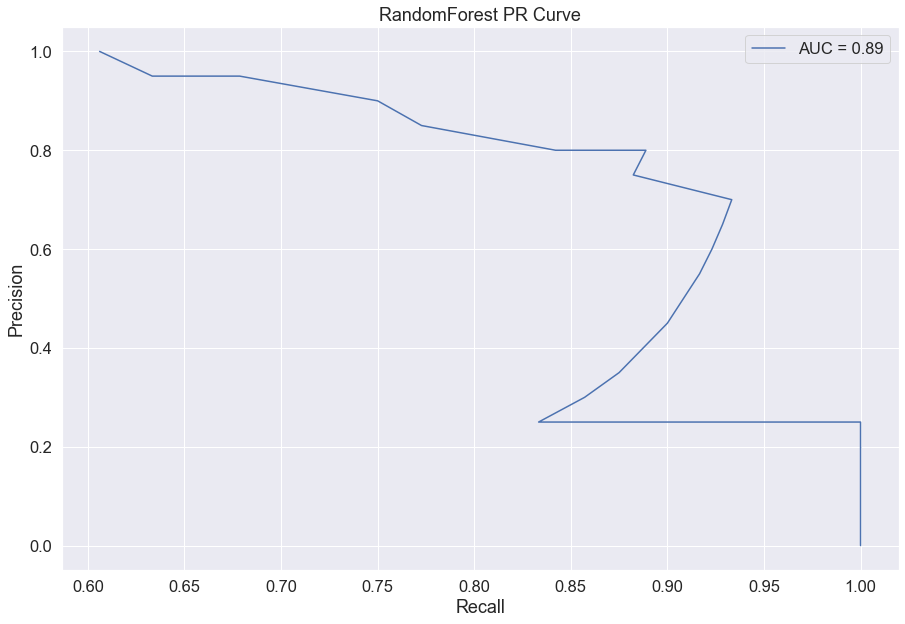

In [86]:
rf_pr_auc = average_precision_score(y_rec_test, rf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % rf_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForest PR Curve')
plt.legend(loc=0)
plt.show()

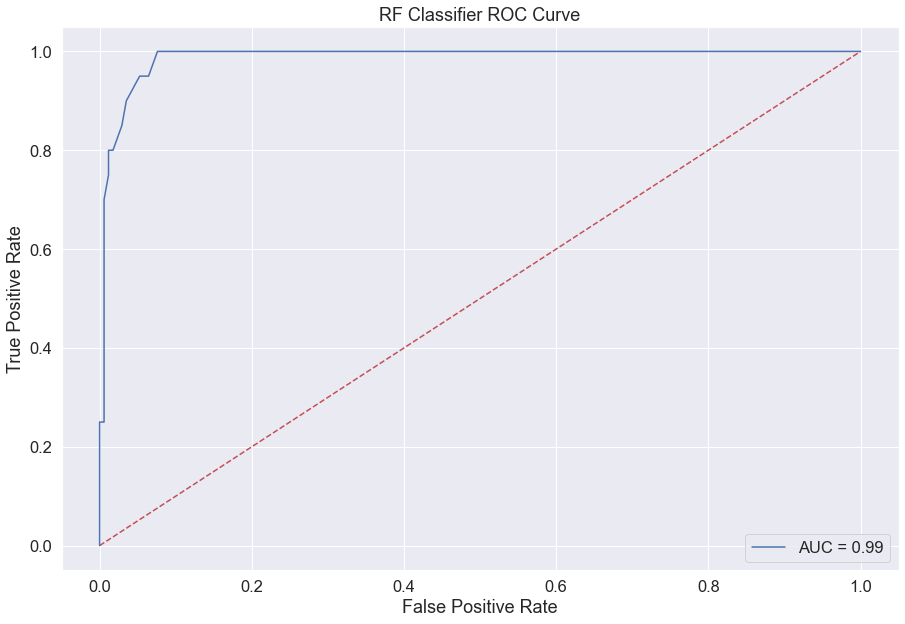

In [87]:
rf_roc_auc = roc_auc_score(y_rec_test, rf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_rec_test, rf.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % rf_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

### Tuned RF

In [88]:
param_dist = {
    'rf__bootstrap': [True],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__max_features': [1, 2, 3],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 4, 6, 8, 10],
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['gini', 'entropy']}

steps = [('sm', sm), ('scaler', StandardScaler()), 
         ('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

rf_cv = GridSearchCV(pipeline, param_grid=param_dist, cv = tscv, n_jobs = -1, verbose = 2)

rf_cv.fit(X_train, y_rec_train)

print("Tuned RandomForest Parameters: {}".format(rf_cv.best_params_))
print("Tuned RandomForest Accuracy: {:.2f}%".format(rf_cv.best_score_*100))
print(classification_report(y_rec_test, rf_cv.predict(X_test)))

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 2796 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 3850 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5064 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6241 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:  2.3min finished


Tuned RandomForest Parameters: {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 3, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 100}
Tuned RandomForest Accuracy: 85.93%
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       171
         1.0       1.00      0.10      0.18        20

    accuracy                           0.91       191
   macro avg       0.95      0.55      0.57       191
weighted avg       0.91      0.91      0.87       191



In [89]:
# Tuning has caused high precision but poor recall (sensitivity).

Text(0.5, 1.0, 'Tuned RandomForest Classifier Confusion Matrix')

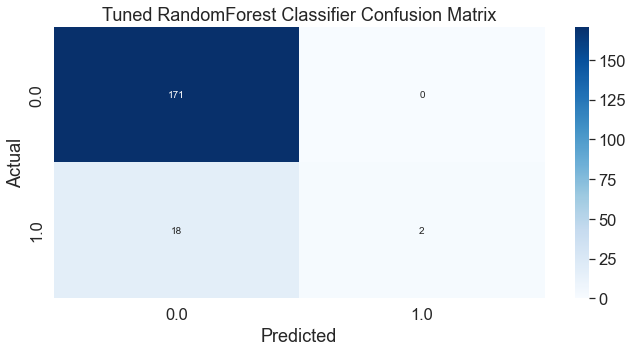

In [90]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, rf_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned RandomForest Classifier Confusion Matrix')

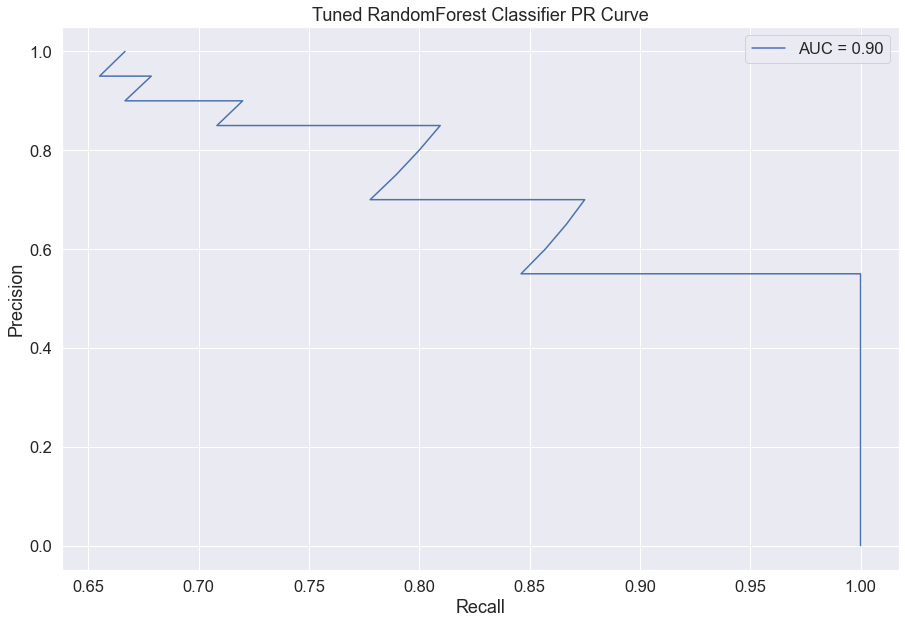

In [91]:
tuned_rf_pr_auc = average_precision_score(y_rec_test, rf_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_rec_test, rf_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_rf_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned RandomForest Classifier PR Curve')
plt.legend(loc=0)
plt.show()

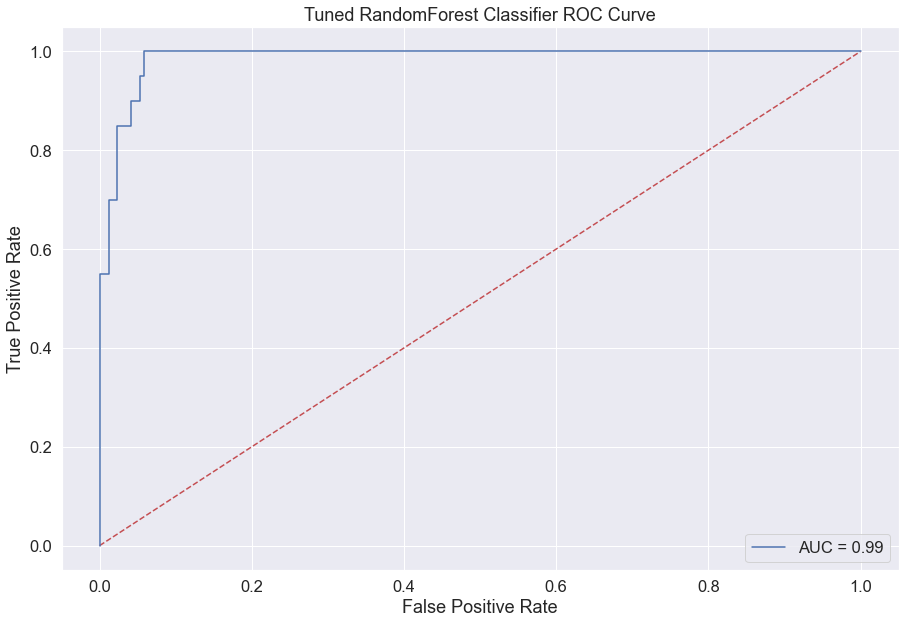

In [92]:
y_rec_predict_prob = rf_cv.predict_proba(X_test)[:,1]

tuned_rf_roc_auc = roc_auc_score(y_rec_test, y_rec_predict_prob)
fpr, tpr, thresholds = roc_curve(y_rec_test, y_rec_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_rf_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned RandomForest Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

In [93]:
# Shows phenomenal ROC despite actually performing relatively poorly. ROC not a good metric when dealing with imbalanced sets.

## XGBoost

In [94]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=1)
xgb.fit(X_train, y_rec_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [95]:
xgb_predict = xgb.predict(X_test)

print("XGBoost Accuracy: {:.2f}%".format(xgb.score(X_test, y_rec_test)*100))
print(classification_report(y_rec_test, xgb_predict))

XGBoost Accuracy: 93.19%
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       171
         1.0       0.89      0.40      0.55        20

    accuracy                           0.93       191
   macro avg       0.91      0.70      0.76       191
weighted avg       0.93      0.93      0.92       191



In [96]:
# Strong precision but below average recall

Text(0.5, 1.0, 'XGBoost Classifier Confusion Matrix')

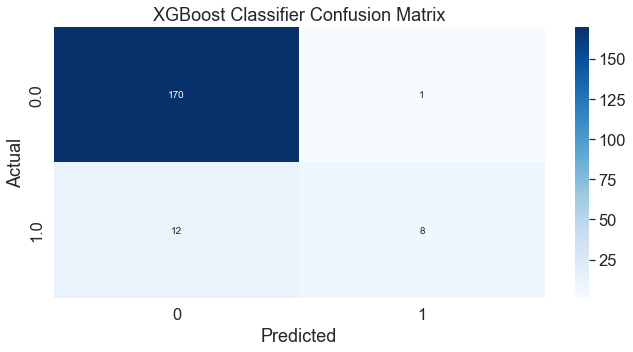

In [97]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, xgb_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('XGBoost Classifier Confusion Matrix')

### Tuned XGBoost Classifier

In [98]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()),
         ('xgb', xgb)])

param_grid = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__max_depth': [3, 4, 5]
        }

xgb_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

xgb_cv.fit(X_train, y_rec_train)

print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))
print("Tuned XGBoost Accuracy: {:.2f}%".format(xgb_cv.best_score_*100))
print(classification_report(y_rec_test, xgb_cv.predict(X_test)))

Tuned XGBoost Parameters: {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 2, 'xgb__max_depth': 3, 'xgb__min_child_weight': 10, 'xgb__subsample': 0.6}
Tuned XGBoost Accuracy: 86.37%
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       171
         1.0       0.93      0.70      0.80        20

    accuracy                           0.96       191
   macro avg       0.95      0.85      0.89       191
weighted avg       0.96      0.96      0.96       191



In [99]:
# Great results. Recall could be better though.

Text(0.5, 1.0, 'Tuned XGBoost Confusion Matrix')

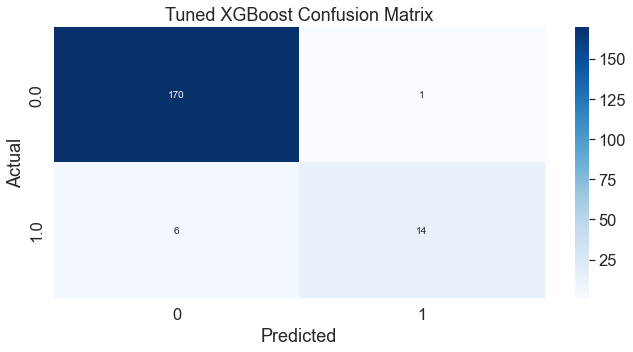

In [100]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_rec_test, xgb_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned XGBoost Confusion Matrix')

In [101]:
# This appears to be the best performance overall.

## Overview:
Not a bad run. I completed the same process with RandomUnderSampling instead of SMOTE. SMOTE was a marginal outperformer for all models, but it did not make much difference.

To improve:

- Utilise a **rolling window CV** (fixed window sizes of train sets) as opposed to a rolling forecast origin may be preferred. There is seemingly no straightforward way of doing this in Python. Annoyingly, all of this can be done easily with caret in r (Using Hyndman's processes (https://robjhyndman.com/hyndsight/tscv/). However, I am not competent in r and would rather find a solution in Python as opposed to moving everything to r and having to learn in limited time...

- **Ensure transofmrations are correct** and potentially scale for all models.

- Potentially run **MIDAS** regressions on original time series data to see if imputing monthly values from quarterly and monthly values from daily data weakens predictions. Unsure if necessary.

- Include Probit model.
    - Include other models (e.g., GLMNET)? Unsure if necessary.

# Recession vs Predictions - Full Sample Runs and Visualisations (1960 - 2021)

In [102]:
targets = [y_rec, y_b]
predictions = pd.concat(targets, axis=1, join='outer')

In [103]:
predictions['usrecession'] = predictions['usrecession'] * 100
predictions['spxbubble'] = predictions['spxbubble'] * 100

In [124]:
xgb_recession = xgb_cv.predict_proba(X)
xgb_recession = pd.DataFrame(xgb_recession[:, 1])
predictions['xgb_recession'] = xgb_recession
predictions['xgb_recession'] = predictions['xgb_recession'] * 100

In [125]:
rf_recession = rf_cv.predict_proba(X)
rf_recession = pd.DataFrame(rf_recession[:, 1])
predictions['rf_recession'] = rf_recession
predictions['rf_recession'] = predictions['rf_recession'] * 100

In [126]:
svc_recession = svc_cv.predict_proba(X)
svc_recession = pd.DataFrame(svc_recession[:, 1])
predictions['svc_recession'] = svc_recession
predictions['svc_recession'] = predictions['svc_recession'] * 100

In [127]:
logit_recession = logit_cv.predict_proba(X)
logit_recession = pd.DataFrame(logit_recession[:, 1])
predictions['logit_recession'] = logit_recession
predictions['logit_recession'] = predictions['logit_recession'] * 100

In [128]:
tree_recession = tree_cv.predict_proba(X)
tree_recession = pd.DataFrame(tree_recession[:, 1])
predictions['tree_recession'] = tree_recession
predictions['tree_recession'] = predictions['tree_recession'] * 100

In [129]:
predictions = predictions.round(decimals = 2);

In [130]:
predictions = predictions.reset_index()

In [131]:
predictions.head()

,index,Date,usrecession,spxbubble,xgb_recession,rf_recession,svc_recession,logit_recession,tree_recession
0,0,1960-03,0.0,0.0,97.010002,30.45,100.00,98.11,76.19
1,1,1960-04,100.0,0.0,70.400002,87.11,15.27,67.47,76.19
2,2,1960-05,100.0,0.0,84.870003,85.53,99.24,95.57,76.19
3,3,1960-06,100.0,0.0,97.970001,89.42,97.21,95.97,76.19
4,4,1960-07,100.0,0.0,97.220001,80.75,95.04,72.20,76.19


In [132]:
predictions['tree_recession'].head()

0    76.19
1    76.19
2    76.19
3    76.19
4    76.19
Name: tree_recession, dtype: float64

In [113]:
# This is weird - coming up with the same numbers throughout the dataset. Unsure what caused that. Removed from chart below.

In [133]:
# Section coded incorrectly. Have to run through 2x to get the df. Otherwise NaN...

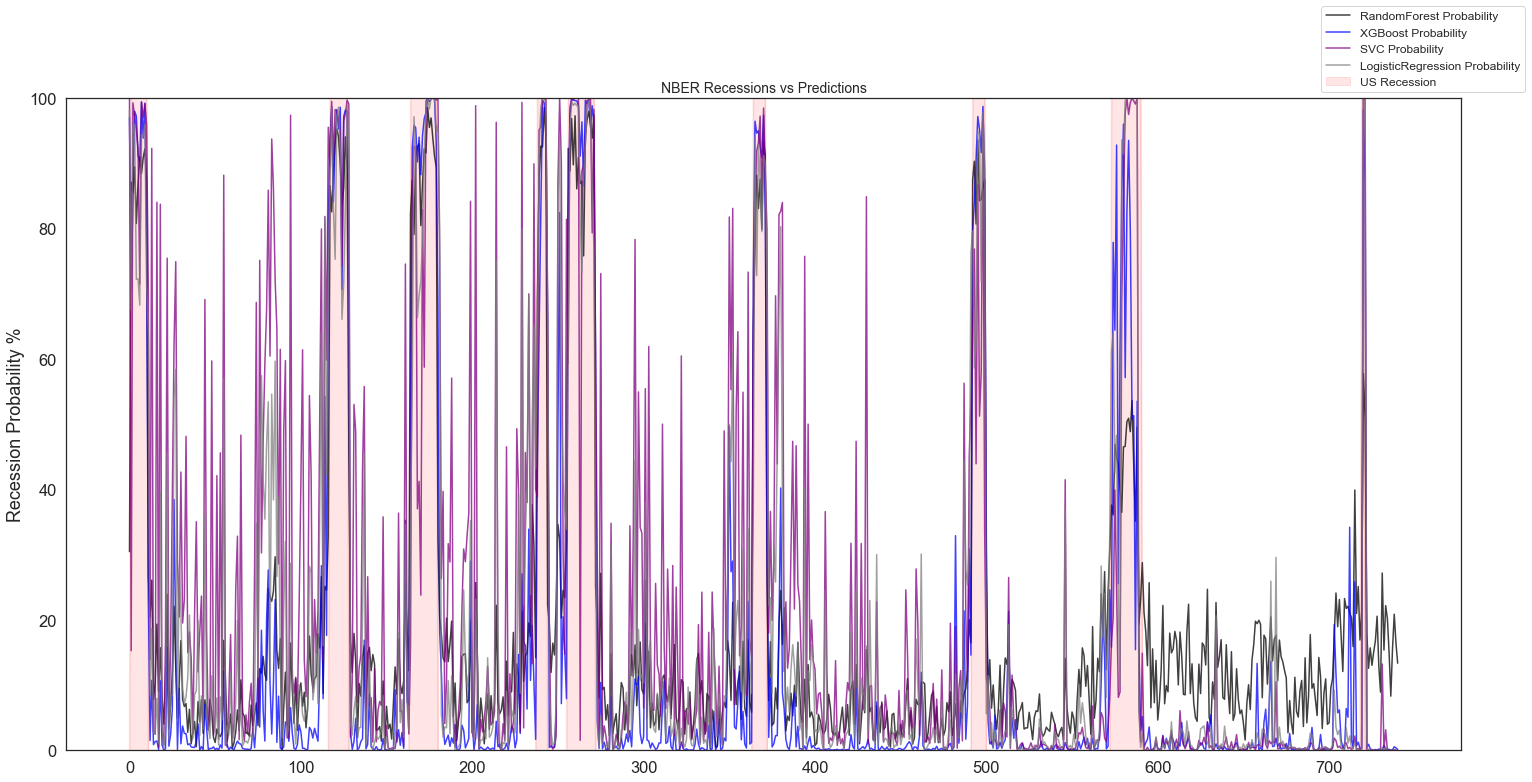

In [134]:
fig, ax = plt.subplots()
predictions['rf_recession'].plot.line(alpha=0.75, color="black", label='RandomForest Probability')
predictions['xgb_recession'].plot.line(alpha=0.75, color="blue", label='XGBoost Probability')
predictions['svc_recession'].plot.line(alpha=0.75, color="purple", label='SVC Probability')
predictions['logit_recession'].plot.line(alpha=0.75, color="grey", label='LogisticRegression Probability')
#predictions['tree_recession'].plot.line(alpha=0.75, color="orange", label='DecisionTree Probability')
predictions['usrecession'].plot.area(figsize=(25, 12), alpha=0.10, x=predictions['Date'], color="red", label = 'US Recession')
plt.ylabel('Recession Probability %')
plt.title('NBER Recessions vs Predictions', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
sns.set_style("white")

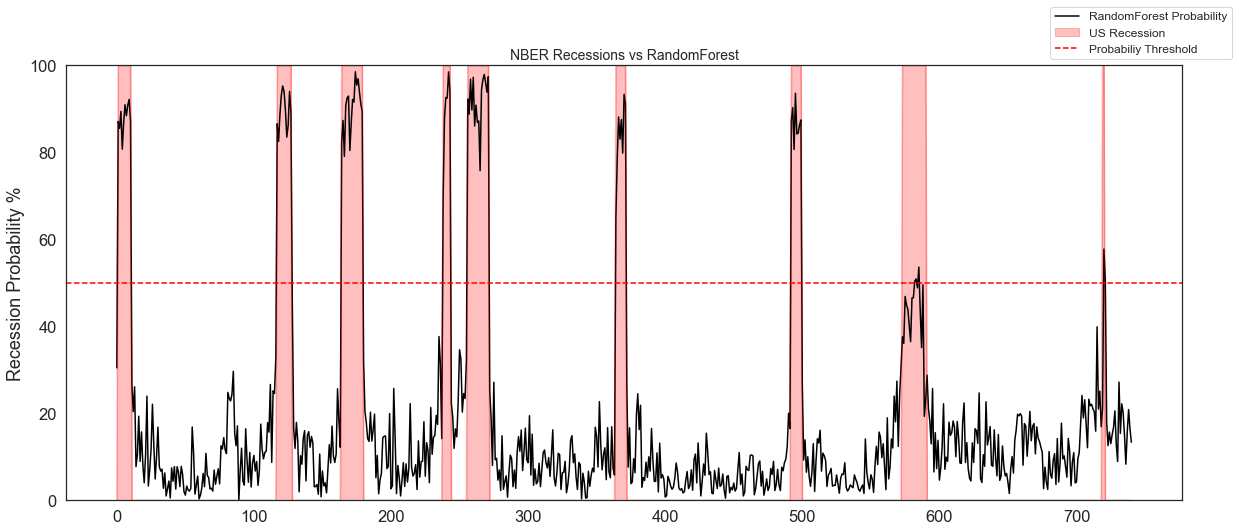

In [135]:
fig, ax = plt.subplots()
predictions['rf_recession'].plot.line(alpha=1, x=predictions['Date'], color="black", label='RandomForest Probability')
predictions['usrecession'].plot.area(figsize=(20, 8), alpha=0.25, x=predictions['Date'], color="red", label = 'US Recession')
plt.axhline(y=50, color = 'red', label= 'Probabiliy Threshold', linestyle='--')
plt.ylabel('Recession Probability %')
plt.title('NBER Recessions vs RandomForest', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
sns.set_style("white")

In [136]:
# Finalised RF

In [137]:
param_dist = {
    'rf__bootstrap': [True],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__max_features': [1, 2, 3],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 4, 6, 8, 10],
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['gini', 'entropy']}

steps = [('sm', sm), ('scaler', StandardScaler()),  # Putting StandardScaler first improved recall by .25 but hindered other results
         ('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

rf_cv = GridSearchCV(pipeline, param_grid=param_dist, cv = tscv, n_jobs = -1, verbose = 2)

rf_cv.fit(X_train, y_rec_train)

print("Tuned RandomForest Parameters: {}".format(rf_cv.best_params_))
print("Tuned RandomForest Accuracy: {:.2f}%".format(rf_cv.best_score_*100))
print(classification_report(y_rec, rf_cv.predict(X)))

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 3281 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4901 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5832 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:  2.4min finished


Tuned RandomForest Parameters: {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 3, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Tuned RandomForest Accuracy: 86.15%
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       646
         1.0       1.00      0.81      0.90        95

    accuracy                           0.98       741
   macro avg       0.99      0.91      0.94       741
weighted avg       0.98      0.98      0.97       741



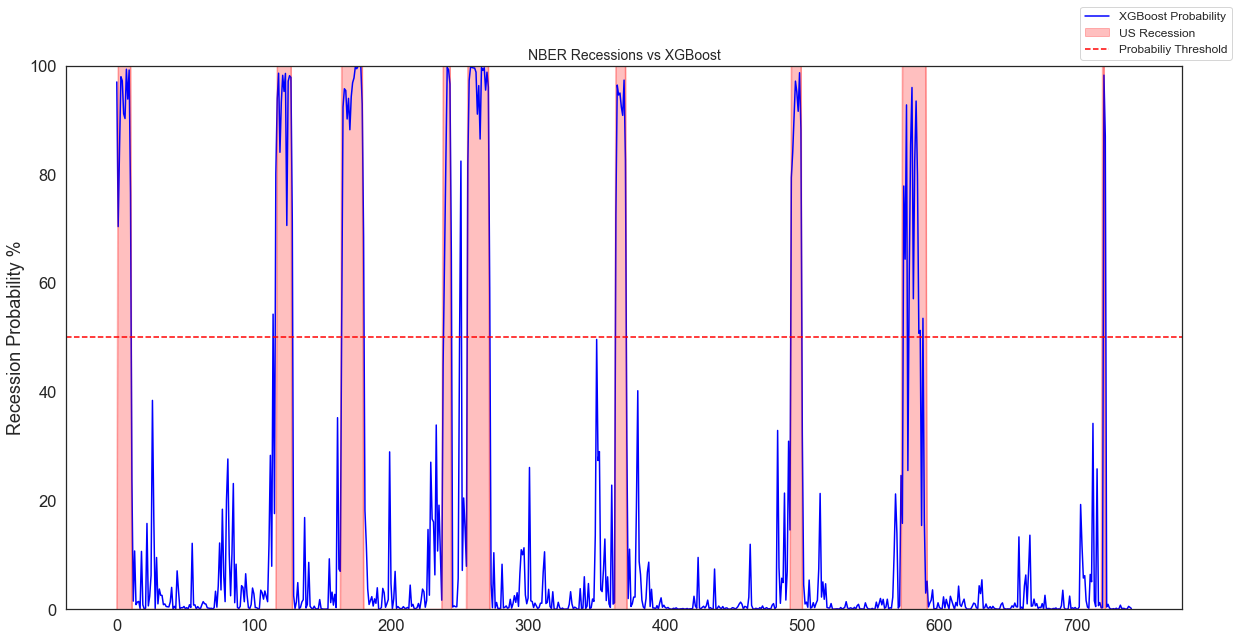

In [138]:
fig, ax = plt.subplots()
predictions['xgb_recession'].plot.line(alpha=1, color="blue", label='XGBoost Probability')
predictions['usrecession'].plot.area(figsize=(20, 10), alpha=0.25, color="red", label = 'US Recession')
plt.axhline(y=50, color = 'red', label= 'Probabiliy Threshold', linestyle='--')
plt.ylabel('Recession Probability %')
plt.title('NBER Recessions vs XGBoost', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
plt.xscale
sns.set_style("white")

In [139]:
# Finalised XGB

In [140]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), 
         ('xgb', xgb)])

param_grid = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__max_depth': [3, 4, 5]
        }

xgb_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

xgb_cv.fit(X_train, y_rec_train)

print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))
print("Tuned XGBoost Accuracy: {:.2f}%".format(xgb_cv.best_score_*100))
print(classification_report(y_rec, xgb_cv.predict(X)))

Tuned XGBoost Parameters: {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 2, 'xgb__max_depth': 3, 'xgb__min_child_weight': 10, 'xgb__subsample': 0.6}
Tuned XGBoost Accuracy: 86.37%
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       646
         1.0       0.91      0.93      0.92        95

    accuracy                           0.98       741
   macro avg       0.95      0.96      0.95       741
weighted avg       0.98      0.98      0.98       741



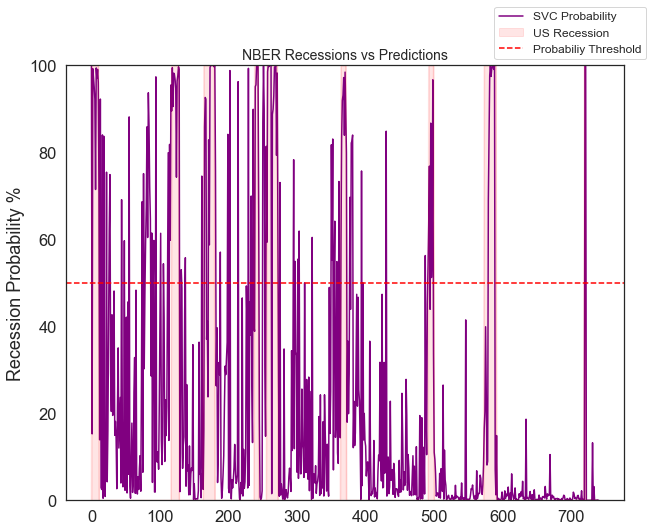

In [141]:
fig, ax = plt.subplots()
predictions['svc_recession'].plot.line(alpha=1, color="purple", label='SVC Probability')
predictions['usrecession'].plot.area(figsize=(10, 8), alpha=0.10, color="red", label = 'US Recession')
plt.ylabel('Recession Probability %')
plt.axhline(y=50, color = 'red', label= 'Probabiliy Threshold', linestyle='--')
plt.title('NBER Recessions vs Predictions', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
sns.set_style("white")

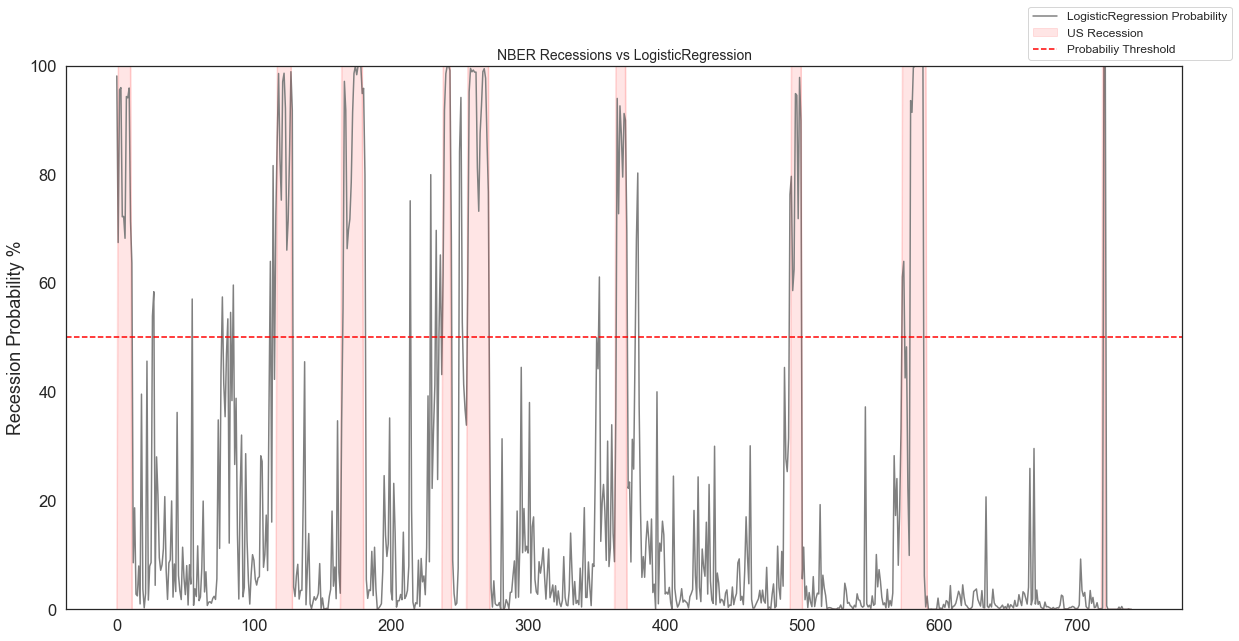

In [142]:
fig, ax = plt.subplots()
predictions['logit_recession'].plot.line(alpha=1, color="grey", label='LogisticRegression Probability')
predictions['usrecession'].plot.area(figsize=(20, 10), alpha=0.10, color="red", label = 'US Recession')
plt.axhline(y=50, color = 'red', label= 'Probabiliy Threshold', linestyle='--')
plt.ylabel('Recession Probability %')
plt.title('NBER Recessions vs LogisticRegression', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
sns.set_style("white")

In [145]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('classifier', LogisticRegression())]) # Should imbalance fixing come before StandardScaler? - smote first slightly improved precision and recall here but unsure why.

cspace = np.logspace(-5, 2, 50)

param_grid = {'classifier__C': cspace, 'classifier__penalty': ['l1', 'l2']}

logit_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

logit_cv.fit(X_train, y_rec_train)

print("Tuned Logistic Regression Parameters: {}".format(logit_cv.best_params_)) 
print("Tuned Logistic Regression Accuracy: {:.2f}%".format(logit_cv.best_score_*100))
print(classification_report(y_rec, logit_cv.predict(X)))

Tuned Logistic Regression Parameters: {'classifier__C': 0.026826957952797246, 'classifier__penalty': 'l2'}
Tuned Logistic Regression Accuracy: 81.10%
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       646
         1.0       0.74      0.91      0.82        95

    accuracy                           0.95       741
   macro avg       0.86      0.93      0.89       741
weighted avg       0.95      0.95      0.95       741



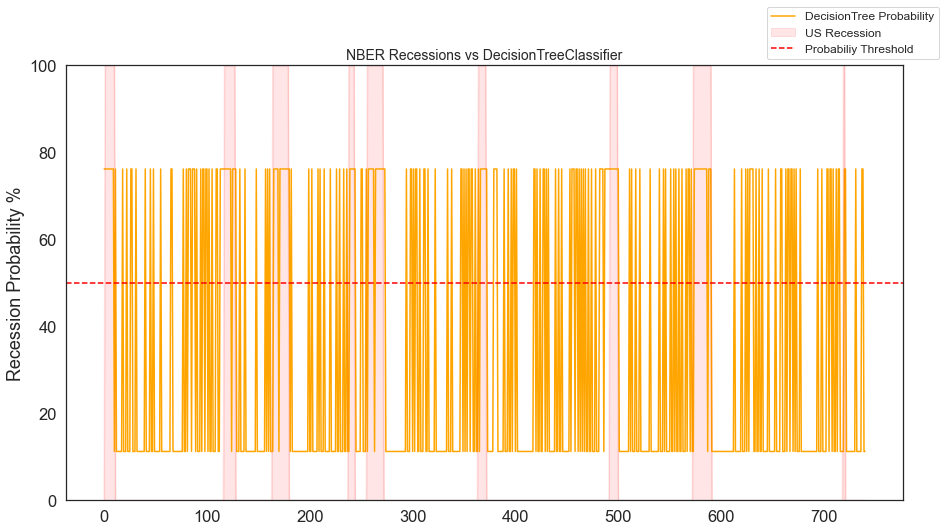

In [146]:
fig, ax = plt.subplots()
predictions['tree_recession'].plot.line(alpha=1, color="orange", label='DecisionTree Probability')
predictions['usrecession'].plot.area(figsize=(15, 8), alpha=0.10, color="red", label = 'US Recession')
plt.ylabel('Recession Probability %')
plt.axhline(y=50, color = 'red', label= 'Probabiliy Threshold', linestyle='--')
plt.title('NBER Recessions vs DecisionTreeClassifier', fontsize=(14))
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=(12), loc=4)
plt.ylim(0, 100)
sns.set_style("white")

In [147]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('tree', tree)])

param_dist = {"tree__max_depth": [1],
              "tree__max_features": range(1, 10),
              "tree__min_samples_leaf": range(1, 10), 
              "tree__criterion": ["gini", "entropy"]}


tree_cv = GridSearchCV(pipeline, param_grid=param_dist, cv=tscv, n_jobs=-1)

tree_cv.fit(X_train, y_rec_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Tuned Decision Tree Accuracy: {:.2f}%".format(tree_cv.best_score_*100))
print(classification_report(y_rec, tree_cv.predict(X)))

Tuned Decision Tree Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__max_features': 1, 'tree__min_samples_leaf': 1}
Tuned Decision Tree Accuracy: 74.73%
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83       646
         1.0       0.32      0.88      0.47        95

    accuracy                           0.74       741
   macro avg       0.65      0.80      0.65       741
weighted avg       0.89      0.74      0.78       741



### Overview

Results look good overall. Cannot tell if I have done the full sample model correctly or if I have overfitted.

NB: Must fix X axes and investigate DecisionTreeClassifier

# 4 - Classification (Bubbles)

In [ ]:
# Should I use multioutput classification instead? It makes sense to do one-by-one because these targets are not always mutually exclusive. Is there a better method?

In [ ]:
# Bubble dates were determined by replicating Phillips et al., (2018) in R on S&P500 data

Text(0, 0.5, 'Number of Bubbles')

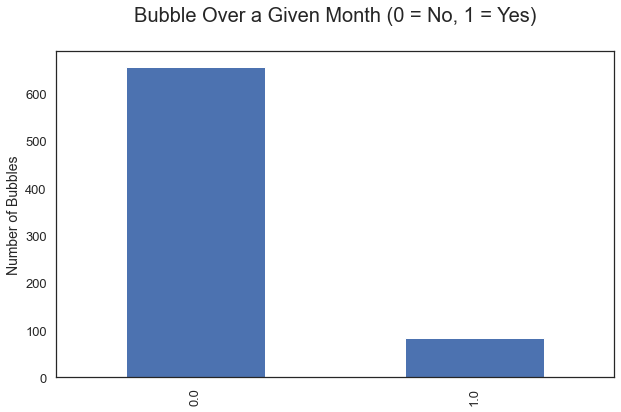

In [149]:
ax = y_b.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13)
ax.set_title('Bubble Over a Given Month (0 = No, 1 = Yes)', size=20, pad=30)
ax.set_ylabel('Number of Bubbles', fontsize=14)

In [150]:
print(y_b.value_counts()) # Slightly more imbalanced than recession data.

0.0    657
1.0     84
Name: spxbubble, dtype: int64


## Cross Validation

In [151]:
tscv = TimeSeriesSplit(n_splits=5)

fold = 1

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index] # is X.iloc correct for test?
    y_train_fold, y_test_fold = y_b.iloc[train_index], y_b.iloc[test_index]
    print('Split %d.' % fold, 'Training set observations: %d,' % len(train_index), 'Testing set observations: %d' % len(test_index))
    fold += 1

Split 1. Training set observations: 126, Testing set observations: 123
Split 2. Training set observations: 249, Testing set observations: 123
Split 3. Training set observations: 372, Testing set observations: 123
Split 4. Training set observations: 495, Testing set observations: 123
Split 5. Training set observations: 618, Testing set observations: 123


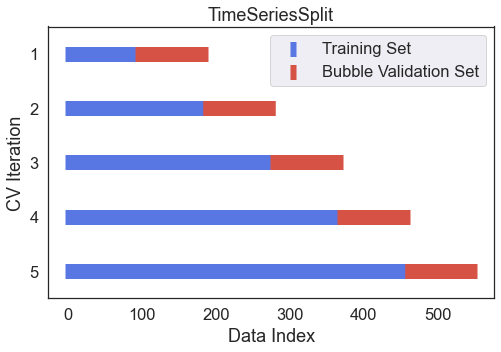

In [152]:
fig, ax = plt.subplots(figsize=(8, 5))

for ii, (tr, tt) in enumerate(tscv.split(X_train, y_b_train)):
    l1 = ax.scatter(tr, [ii+1] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=15)
    l2 = ax.scatter(tt, [ii+1] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=15)
    ax.set(ylim=[5.5, 0.5], title='TimeSeriesSplit', xlabel='Data Index', ylabel='CV Iteration')
    ax.legend([l1, l2], ['Training Set', 'Bubble Validation Set'], loc=0)
    sns.set_style("darkgrid")

## LogisticRegression

In [153]:
b_logit = LogisticRegression(random_state=1)
b_logit.fit(X_train, y_b_train)
print("Logistic Regression Accuracy: {:.2f}%".format(b_logit.score(X_test, y_b_test)*100))
print(classification_report(y_b_test, b_logit.predict(X_test)))

Logistic Regression Accuracy: 46.07%
              precision    recall  f1-score   support

         0.0       0.92      0.47      0.62       181
         1.0       0.03      0.30      0.06        10

    accuracy                           0.46       191
   macro avg       0.48      0.38      0.34       191
weighted avg       0.88      0.46      0.59       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

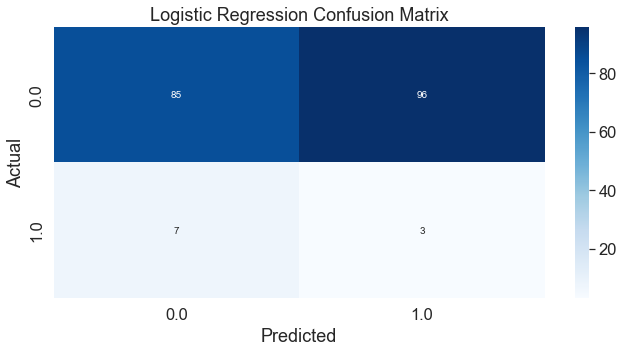

In [154]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, b_logit.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Logistic Regression Confusion Matrix')

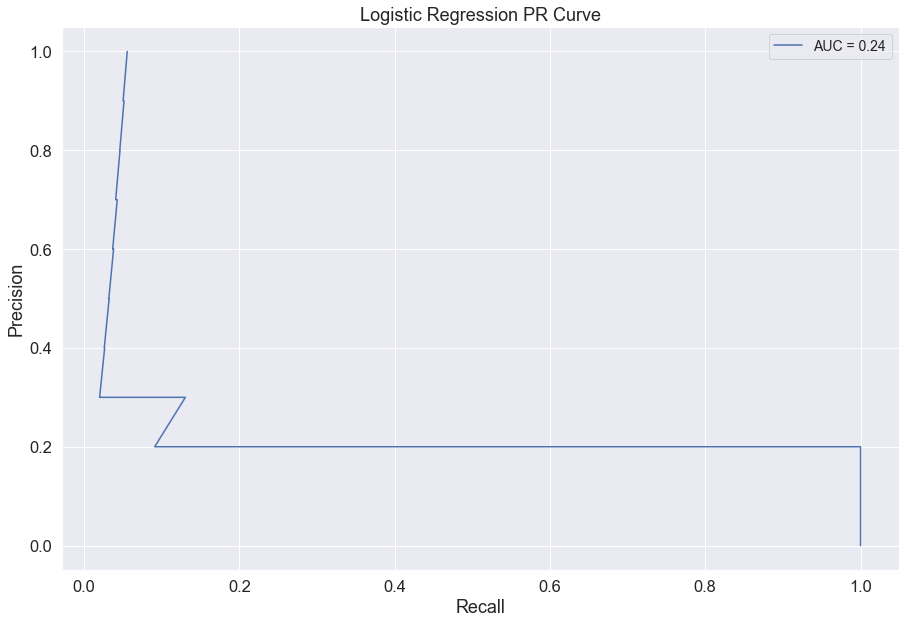

In [155]:
b_logit_pr_auc = average_precision_score(y_b_test, b_logit.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, b_logit.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % b_logit_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression PR Curve')
plt.legend(fontsize=14, loc=0)
plt.show()

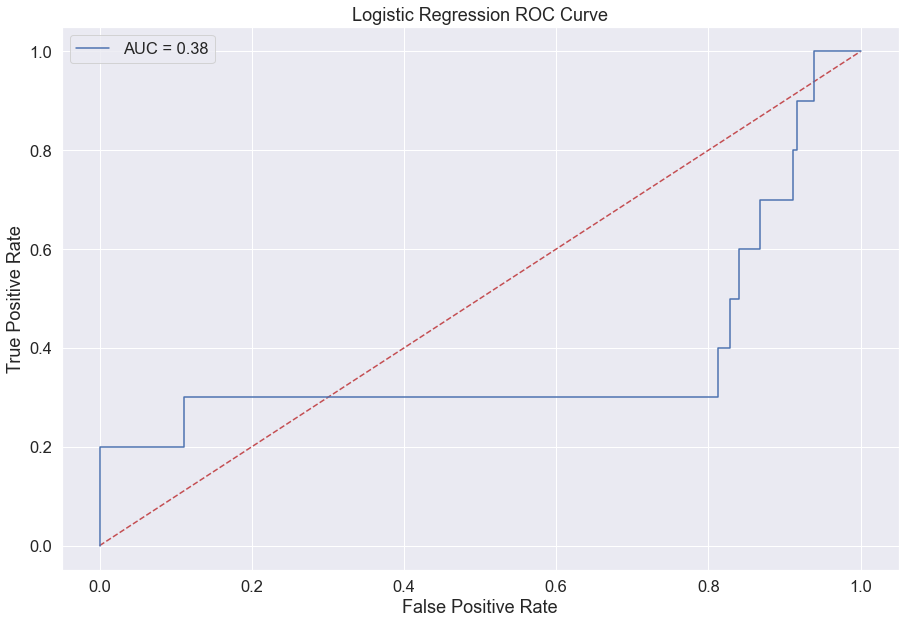

In [156]:
b_logit_roc_auc = roc_auc_score(y_b_test, b_logit.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_b_test, b_logit.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % b_logit_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc=0)
plt.show()

### Tuned LogisticRegression

In [157]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('classifier', LogisticRegression())])

cspace = np.logspace(-5, 2, 50)

param_grid = {'classifier__C': cspace, 'classifier__penalty': ['l2']} # l1 producing same error as recession logit

b_logit_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

b_logit_cv.fit(X_train, y_b_train)

print("Tuned Logistic Regression Parameters: {}".format(b_logit_cv.best_params_)) 
print("Tuned Logistic Regression Accuracy: {:.2f}%".format(b_logit_cv.best_score_*100))
print(classification_report(y_b_test, b_logit_cv.predict(X_test)))

Tuned Logistic Regression Parameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2'}
Tuned Logistic Regression Accuracy: nan%
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       181
         1.0       0.05      1.00      0.10        10

    accuracy                           0.06       191
   macro avg       0.53      0.50      0.06       191
weighted avg       0.95      0.06      0.02       191



Text(0.5, 1.0, 'Tuned Logistic Regression Confusion Matrix')

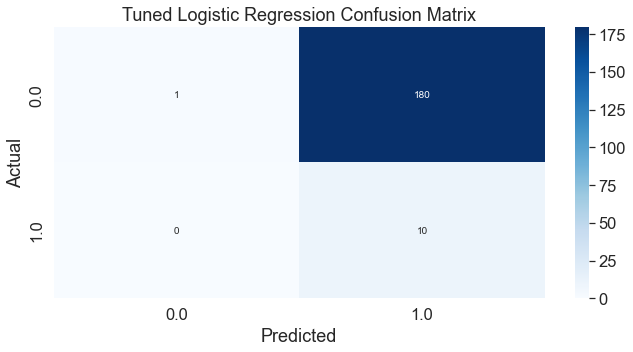

In [158]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, b_logit_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Logistic Regression Confusion Matrix')

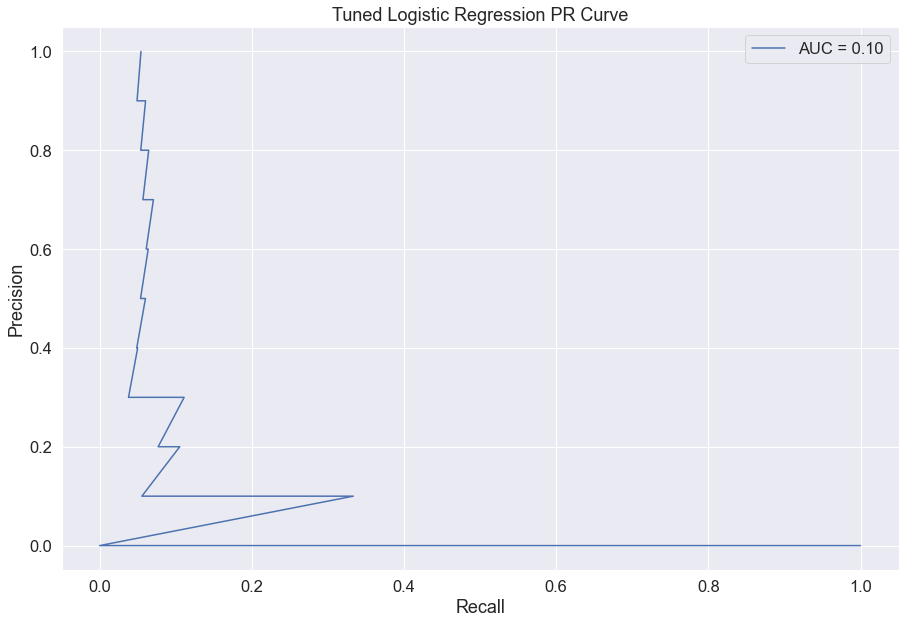

In [159]:
b_logit_pr_auc = average_precision_score(y_b_test, b_logit_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, b_logit_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % b_logit_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Logistic Regression PR Curve')
plt.legend(loc=0)
plt.show()

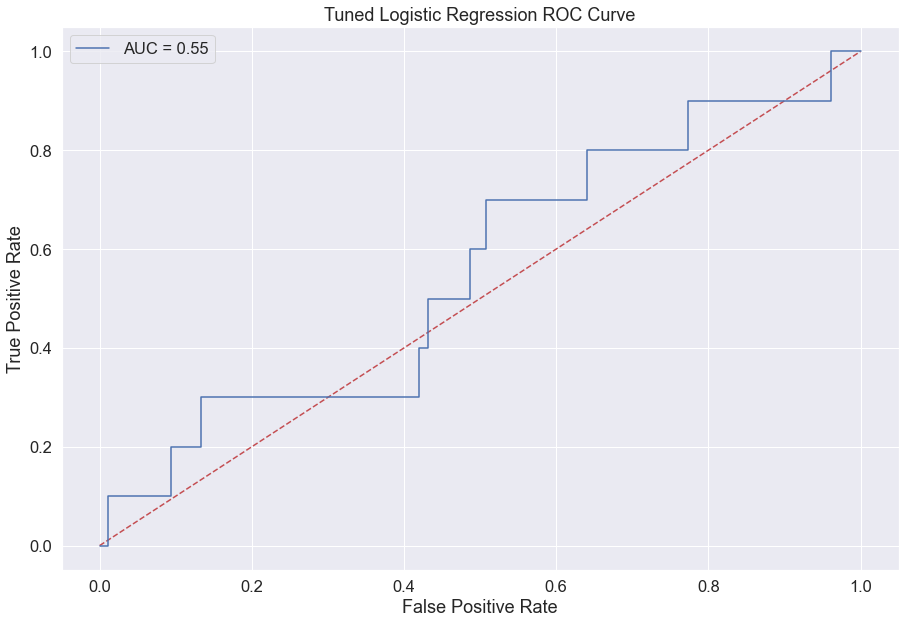

In [160]:
y_b_predict_prob = b_logit_cv.predict_proba(X_test)[:,1]

b_logit_roc_auc = roc_auc_score(y_b_test, y_b_predict_prob)
fpr, tpr, thresholds = roc_curve(y_b_test, y_b_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % b_logit_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Logistic Regression ROC Curve')
plt.legend(loc=0)
plt.show()

## Decision Tree Classifier

In [161]:
btree = DecisionTreeClassifier(random_state=1)

btree.fit(X_train, y_b_train)

btreepredict = btree.predict(X_test)

print("Decision Tree Accuracy: {:.2f}%".format(btree.score(X_test, y_b_test)*100))
print(classification_report(y_b_test, btreepredict))

Decision Tree Accuracy: 94.76%
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       181
         1.0       0.00      0.00      0.00        10

    accuracy                           0.95       191
   macro avg       0.47      0.50      0.49       191
weighted avg       0.90      0.95      0.92       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix')

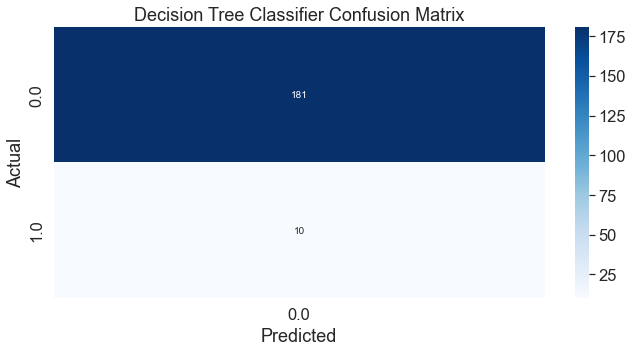

In [162]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, btreepredict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Decision Tree Classifier Confusion Matrix')

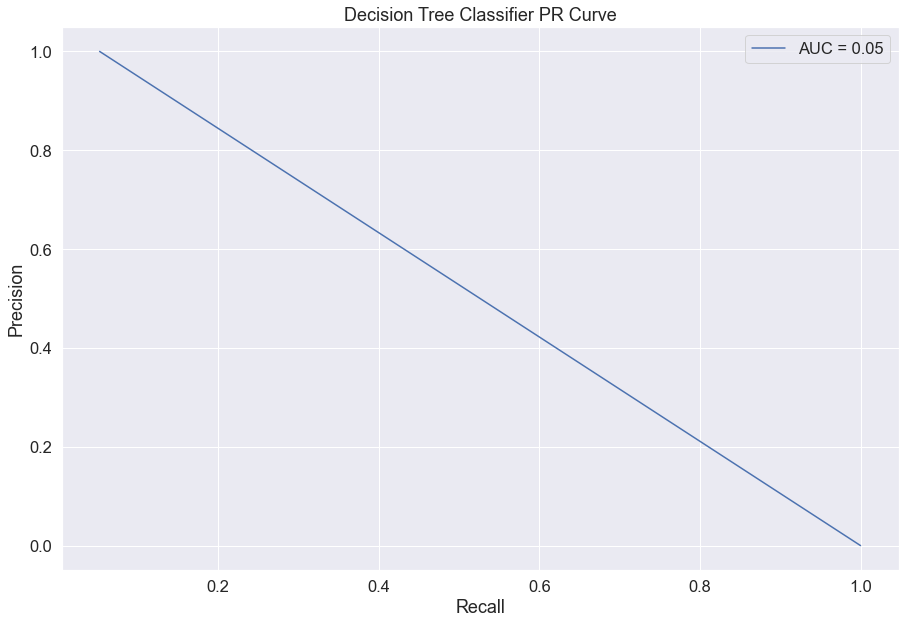

In [163]:
btree_pr_auc = average_precision_score(y_b_test, btree.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, btree.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % btree_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Classifier PR Curve')
plt.legend(loc=0)
plt.show()

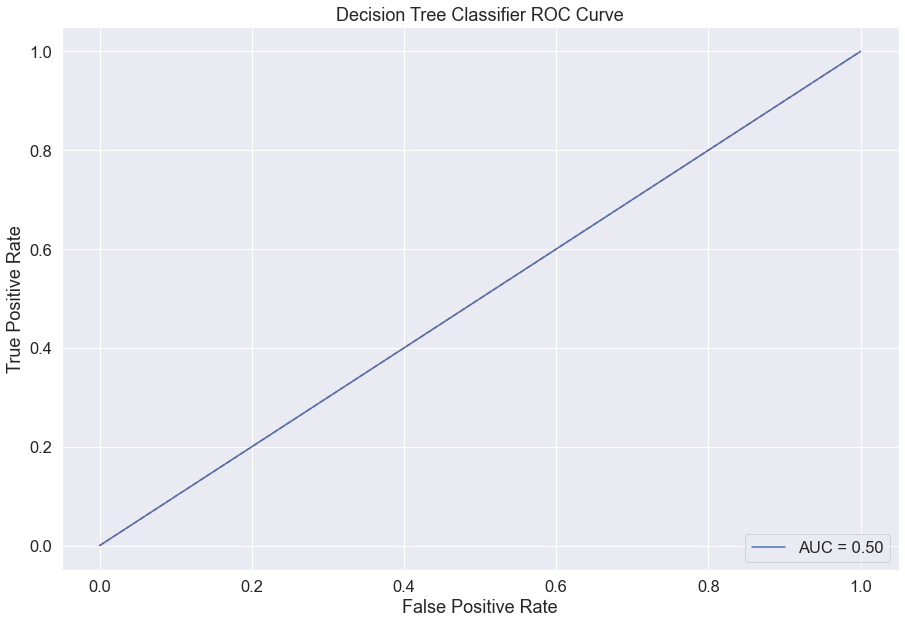

In [164]:
y_b_predict_prob = btree.predict_proba(X_test)[:,1]

btree_roc_auc = roc_auc_score(y_b_test, y_b_predict_prob)
fpr, tpr, thresholds = roc_curve(y_b_test, y_b_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % btree_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curve')
plt.legend(loc=4)
plt.show()

### Tuned Decision Tree Classifier

In [165]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), ('tree', btree)])

param_dist = {"tree__max_depth": [1],
              "tree__max_features": range(1, 10),
              "tree__min_samples_leaf": range(1, 10), 
              "tree__criterion": ["gini", "entropy"]}


btree_cv = GridSearchCV(pipeline, param_grid=param_dist, cv=tscv, n_jobs=-1)

btree_cv.fit(X_train, y_b_train)

print("Tuned Decision Tree Parameters: {}".format(btree_cv.best_params_))
print("Tuned Decision Tree Accuracy: {:.2f}%".format(btree_cv.best_score_*100))
print(classification_report(y_b_test, btree_cv.predict(X_test)))

Tuned Decision Tree Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__max_features': 1, 'tree__min_samples_leaf': 1}
Tuned Decision Tree Accuracy: nan%
              precision    recall  f1-score   support

         0.0       0.95      0.20      0.33       181
         1.0       0.05      0.80      0.10        10

    accuracy                           0.23       191
   macro avg       0.50      0.50      0.21       191
weighted avg       0.90      0.23      0.32       191



In [166]:
# Appalling precision

Text(0.5, 1.0, 'Tuned Decision Tree Classifier Confusion Matrix')

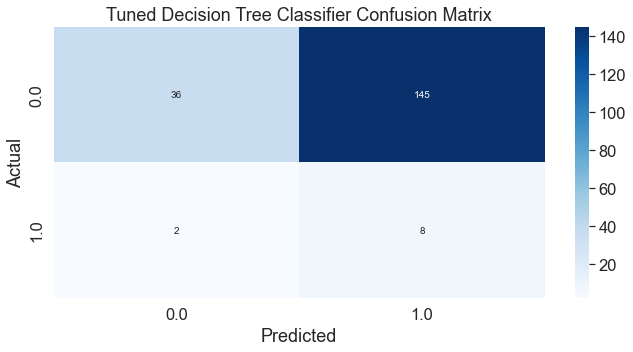

In [167]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, btree_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Decision Tree Classifier Confusion Matrix')

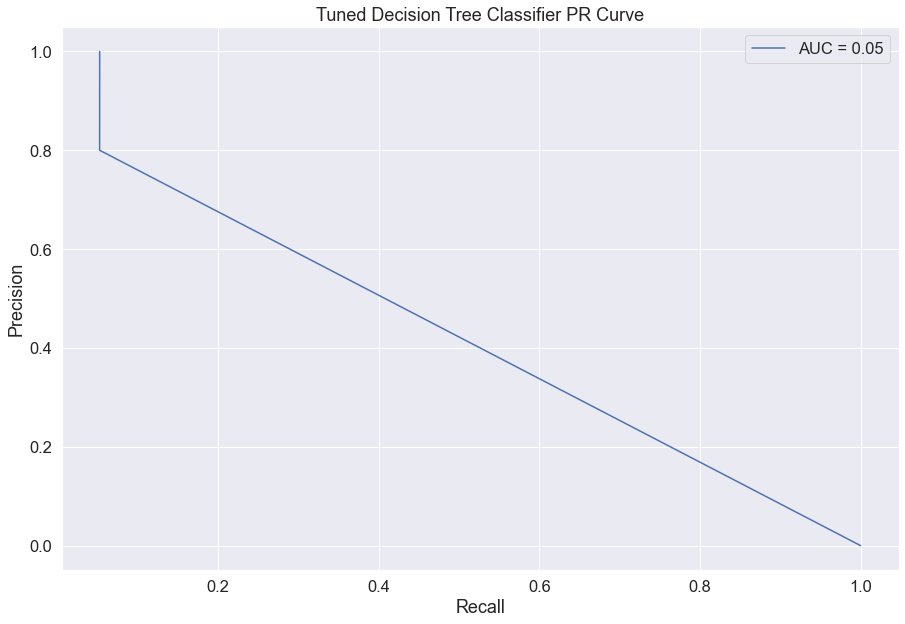

In [168]:
tuned_btree_pr_auc = average_precision_score(y_b_test, btree_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, btree_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_btree_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Decision Tree Classifier PR Curve')
plt.legend(loc=0)
plt.show()

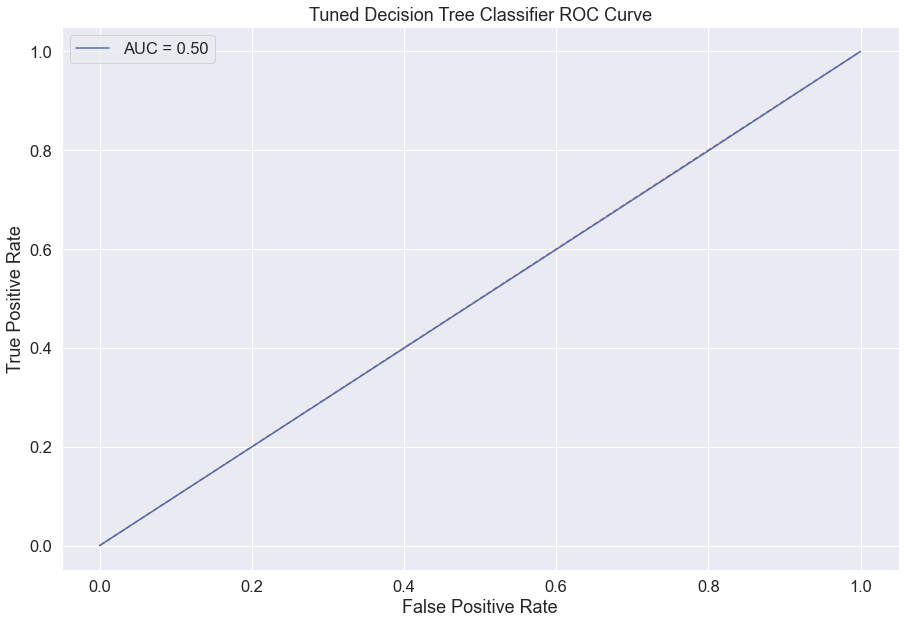

In [169]:
y_b_predict_prob = btree_cv.predict_proba(X_test)[:,1]

tuned_btree_roc_auc = roc_auc_score(y_b_test, y_b_predict_prob)
fpr, tpr, thresholds = roc_curve(y_b_test, y_b_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_btree_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Decision Tree Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

## Support Vector Classification

In [170]:
bsvc = SVC(probability=True, random_state=1)

bsvc.fit(X_train, y_b_train)

bsvc_predict = bsvc.predict(X_test)

print("Support Vector Classifier Accuracy: {:.2f}%".format(bsvc.score(X_test, y_b_test)*100))
print(classification_report(y_b_test, bsvc_predict))

Support Vector Classifier Accuracy: 94.76%
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       181
         1.0       0.00      0.00      0.00        10

    accuracy                           0.95       191
   macro avg       0.47      0.50      0.49       191
weighted avg       0.90      0.95      0.92       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'Support Vector Classifier Confusion Matrix')

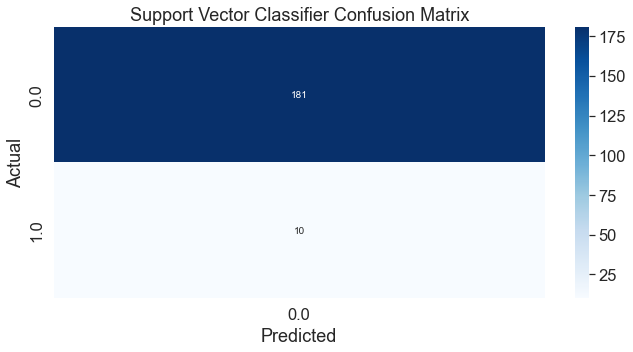

In [171]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, bsvc_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Support Vector Classifier Confusion Matrix')

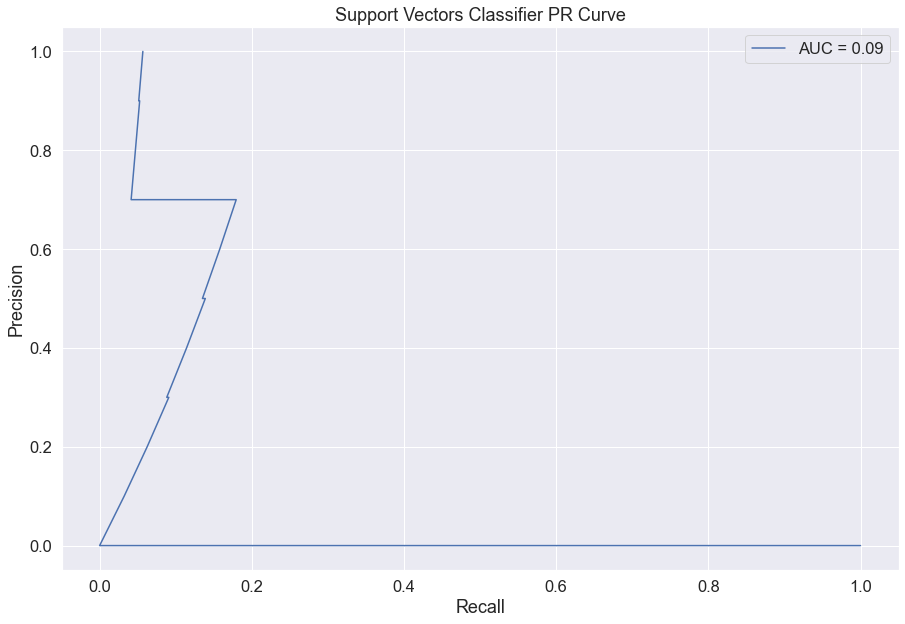

In [172]:
bsvc_pr_auc = average_precision_score(y_b_test, bsvc.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, bsvc.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % bsvc_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Support Vectors Classifier PR Curve')
plt.legend(loc=0)
plt.show()

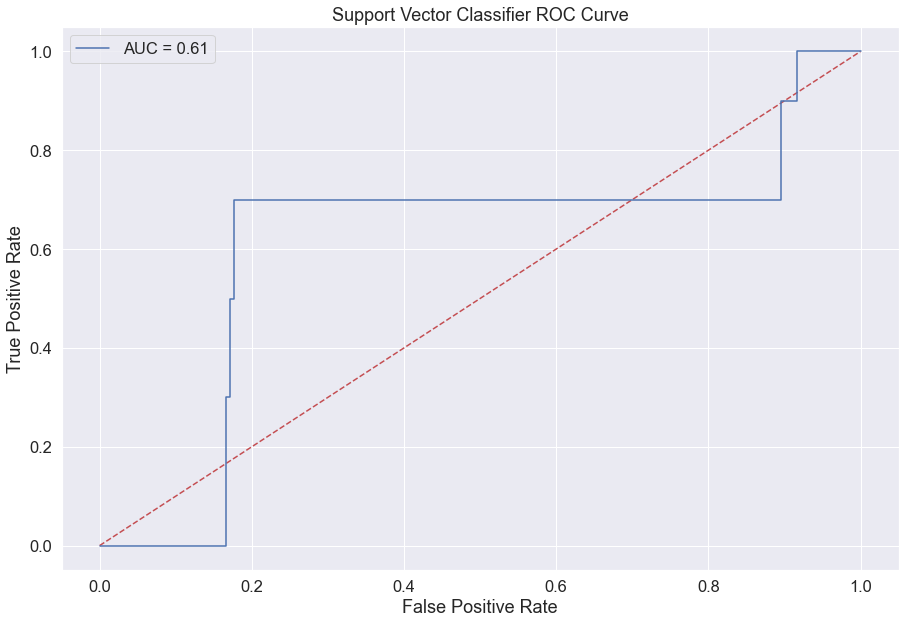

In [173]:
bsvc_roc_auc = roc_auc_score(y_b_test, bsvc.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_b_test, bsvc.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % bsvc_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

In [174]:
# Still scored well on ROC because majority class is no recession. This shows that ROC is a poor metric for performance when dealing with imbalanced sets.

### Tuned SVM with Radial Basis Function

In [175]:
# SVM requires StandardScaler on training set because the features with the largest range will completely dominate in the computation of the kernel matrix if not scaled
# If this is the case - should I scale my other models to increase comparability even though other models do not require it in the same way as SVM?

In [176]:
steps = [('sm', sm), ('scaler', StandardScaler()), # Having SMOTE before StandardScaler here has significantly improved recall (0.1 to 0.5)...
        ('SVC', SVC(probability=True, random_state=1))]

c_space = np.logspace(-5, 2, 50)
param_dist = {'SVC__C': c_space, 'SVC__kernel': ['linear', 'rbf'], 'SVC__gamma': ['scale', 'auto']}

pipeline = Pipeline(steps)

bsvc_cv = GridSearchCV(pipeline, param_grid=param_dist, cv=tscv, n_jobs=-1)

bsvc_cv.fit(X_train, y_b_train)

print("Tuned Support Vector Classifier with Scaled Parameters: {}".format(bsvc_cv.best_params_)) 
print('Tuned Support Vector Classifier with Scaled Accuracy: {:.2f}%'.format(bsvc_cv.score(X_test, y_b_test)*100))
print(classification_report(y_b_test, bsvc_cv.predict(X_test)))

Tuned Support Vector Classifier with Scaled Parameters: {'SVC__C': 1e-05, 'SVC__gamma': 'scale', 'SVC__kernel': 'linear'}
Tuned Support Vector Classifier with Scaled Accuracy: 5.76%
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       181
         1.0       0.05      1.00      0.10        10

    accuracy                           0.06       191
   macro avg       0.53      0.50      0.06       191
weighted avg       0.95      0.06      0.02       191



Text(0.5, 1.0, 'Tuned Support Vector Classifier Confusion Matrix')

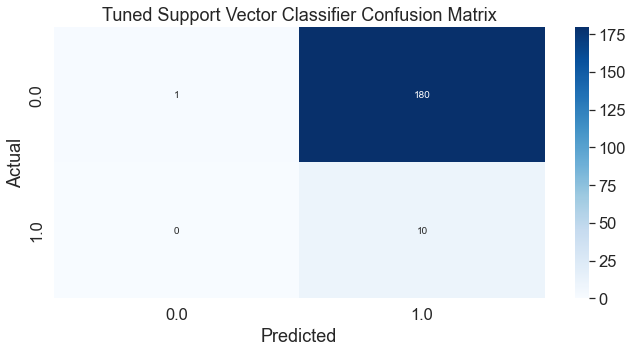

In [177]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, bsvc_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned Support Vector Classifier Confusion Matrix')

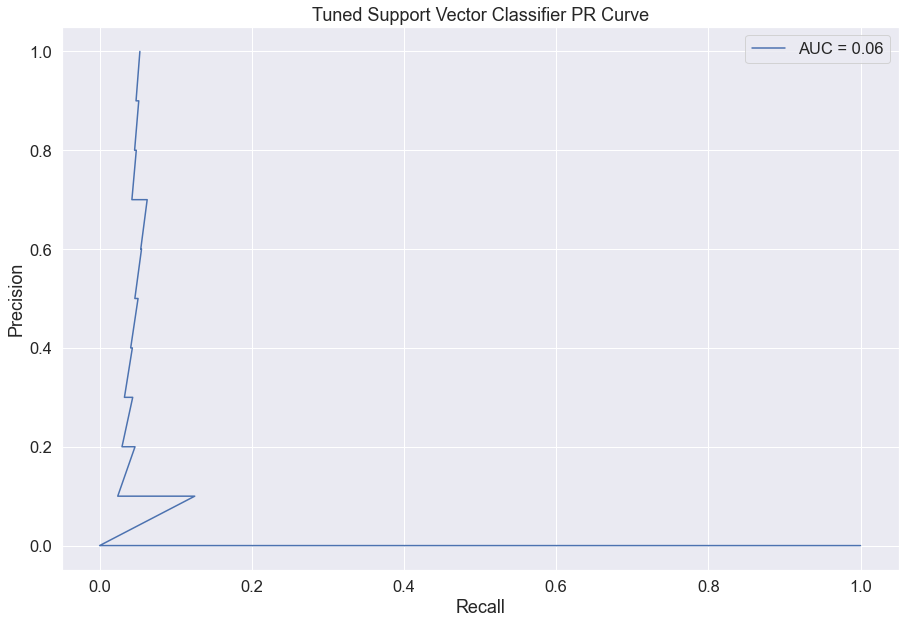

In [178]:
tuned_bsvc_pr_auc = average_precision_score(y_b_test, bsvc_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, bsvc_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_bsvc_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Support Vector Classifier PR Curve')
plt.legend(loc=0)
plt.show()

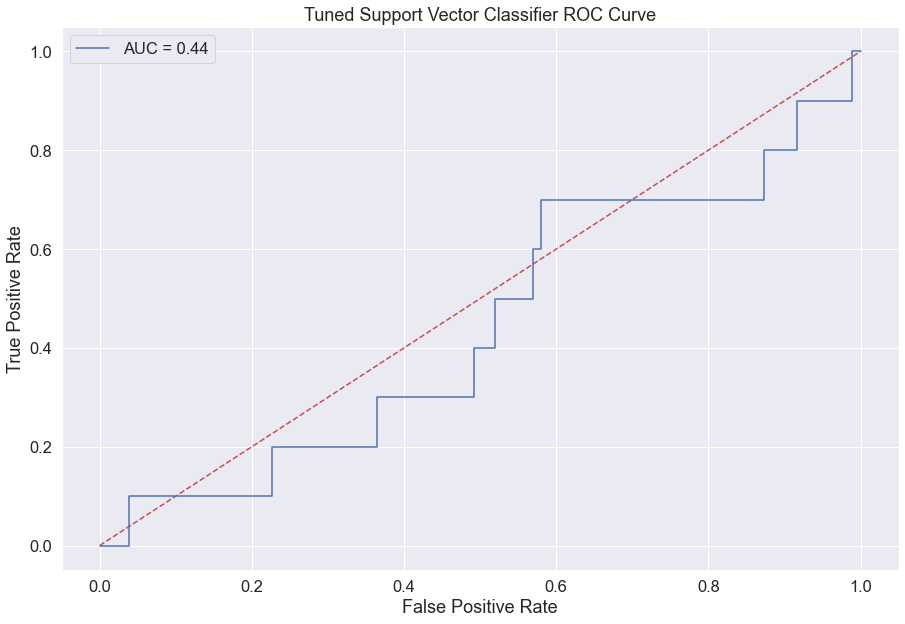

In [179]:
y_b_predict_prob = bsvc_cv.predict_proba(X_test)[:,1]

tuned_bsvc_roc_auc = roc_auc_score(y_b_test, y_b_predict_prob)
fpr, tpr, thresholds = roc_curve(y_b_test, y_b_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_bsvc_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Support Vector Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

## RandomForest Classification

In [180]:
brf = RandomForestClassifier(random_state=1)

brf.fit(X_train, y_b_train)

brf_predict = brf.predict(X_test)

print("Decision Tree Accuracy: {:.2f}%".format(rf.score(X_test, y_b_test)*100))
print(classification_report(y_b_test, brf_predict))

Decision Tree Accuracy: 96.34%
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       181
         1.0       0.00      0.00      0.00        10

    accuracy                           0.95       191
   macro avg       0.47      0.50      0.49       191
weighted avg       0.90      0.95      0.92       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [181]:
# Poor recall.

Text(0.5, 1.0, 'RandomForest Classifier Confusion Matrix')

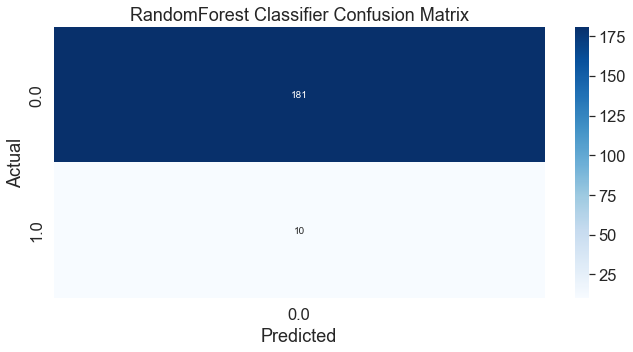

In [182]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, brf_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('RandomForest Classifier Confusion Matrix')

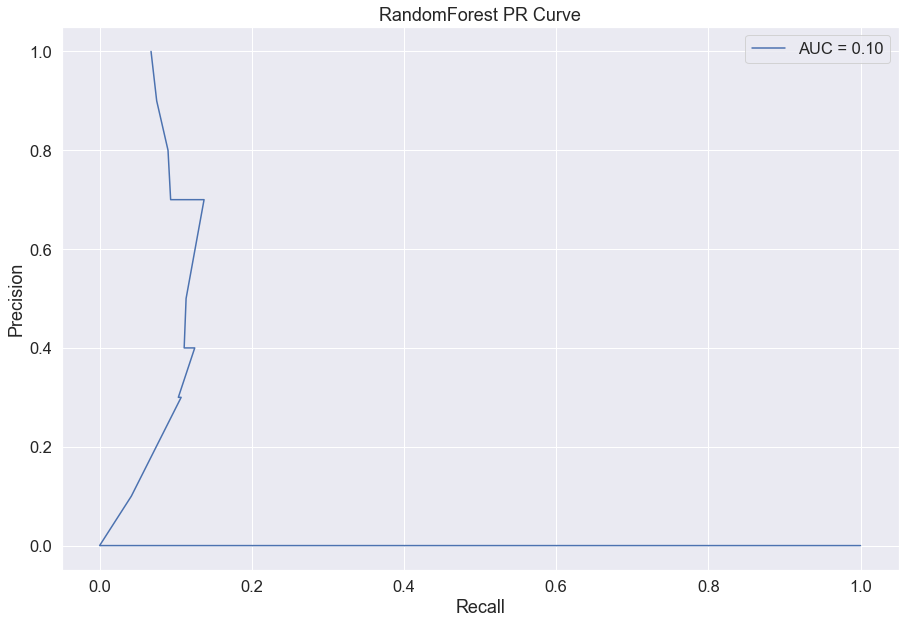

In [183]:
brf_pr_auc = average_precision_score(y_b_test, brf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, brf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % brf_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForest PR Curve')
plt.legend(loc=0)
plt.show()

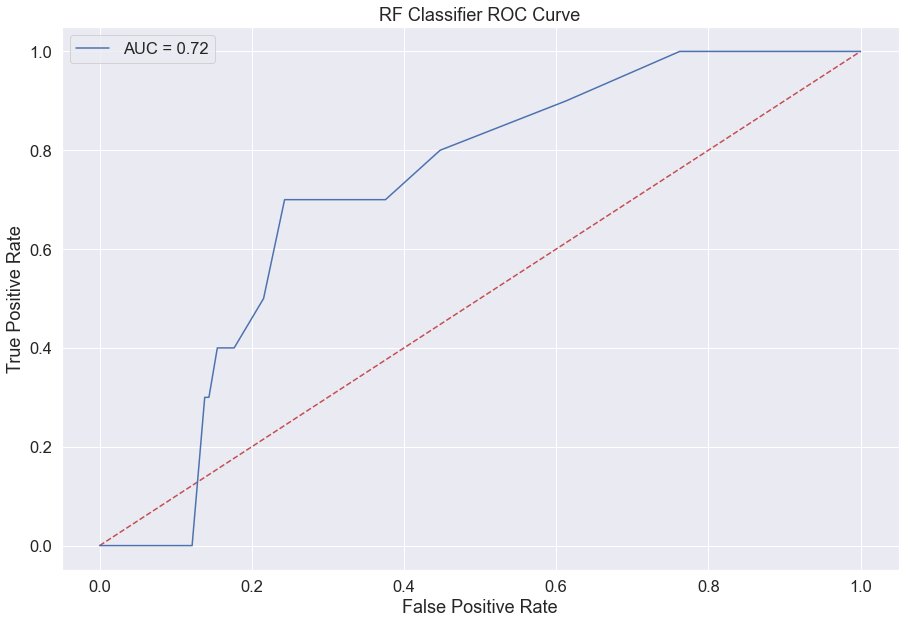

In [184]:
brf_roc_auc = roc_auc_score(y_b_test, brf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_b_test, brf.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % brf_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

### Tuned RF

In [ ]:
param_dist = {
    'rf__bootstrap': [True],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__max_features': [1, 2, 3],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 4, 6, 8, 10],
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['gini', 'entropy']}

steps = [('sm', sm), ('scaler', StandardScaler()), 
         ('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

rf_cv = GridSearchCV(pipeline, param_grid=param_dist, cv = tscv, n_jobs = -1, verbose = 2)

rf_cv.fit(X_train, y_rec_train)

print("Tuned RandomForest Parameters: {}".format(rf_cv.best_params_))
print("Tuned RandomForest Accuracy: {:.2f}%".format(rf_cv.best_score_*100))
print(classification_report(y_b_test, rf_cv.predict(X_test)))

In [190]:
param_dist = {
    'brf__bootstrap': [True],
    'brf__max_depth': [10, 20, 30, 40, 50],
    'brf__max_features': [1, 2, 3],
    'brf__min_samples_leaf': [1, 2, 3],
    'brf__min_samples_split': [2, 4, 6, 8, 10],
    'brf__n_estimators': [100, 200, 300],
    'brf__criterion': ['gini', 'entropy']}

steps = [('sm', sm), ('scaler', StandardScaler()),
         ('brf', RandomForestClassifier())]

pipeline = Pipeline(steps)

brf_cv = GridSearchCV(pipeline, param_grid=param_dist, cv = tscv, n_jobs = -1, verbose = 2)

brf_cv.fit(X_train, y_b_train)

print("Tuned Decision Tree Parameters: {}".format(brf_cv.best_params_))
print("Tuned Decision Tree Accuracy: {:.2f}%".format(brf_cv.best_score_*100))
print(classification_report(y_b_test, brf_cv.predict(X_test)))

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1945 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 3241 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 5502 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 6711 out of 6750 | elapsed:  1.1min remaining:    0.3s


Tuned Decision Tree Parameters: {'brf__bootstrap': True, 'brf__criterion': 'gini', 'brf__max_depth': 10, 'brf__max_features': 1, 'brf__min_samples_leaf': 1, 'brf__min_samples_split': 2, 'brf__n_estimators': 100}
Tuned Decision Tree Accuracy: nan%
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       181
         1.0       0.00      0.00      0.00        10

    accuracy                           0.90       191
   macro avg       0.47      0.48      0.47       191
weighted avg       0.90      0.90      0.90       191



[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:  1.1min finished


Text(0.5, 1.0, 'Tuned RandomForest Classifier Confusion Matrix')

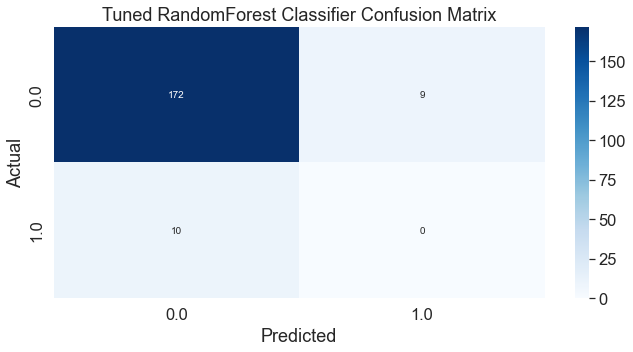

In [191]:
fig, ax = plt.subplots(figsize=(11, 5))
confusion_matrix = pd.crosstab(y_b_test, brf_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
ax.set_title('Tuned RandomForest Classifier Confusion Matrix')

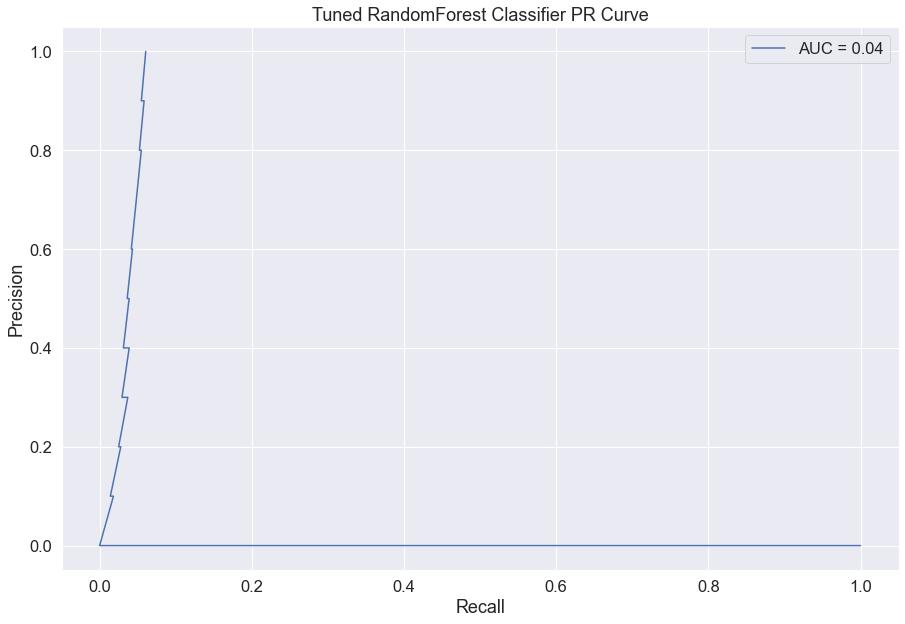

In [192]:
tuned_brf_pr_auc = average_precision_score(y_b_test, brf_cv.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = precision_recall_curve(y_b_test, brf_cv.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_brf_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned RandomForest Classifier PR Curve')
plt.legend(loc=0)
plt.show()

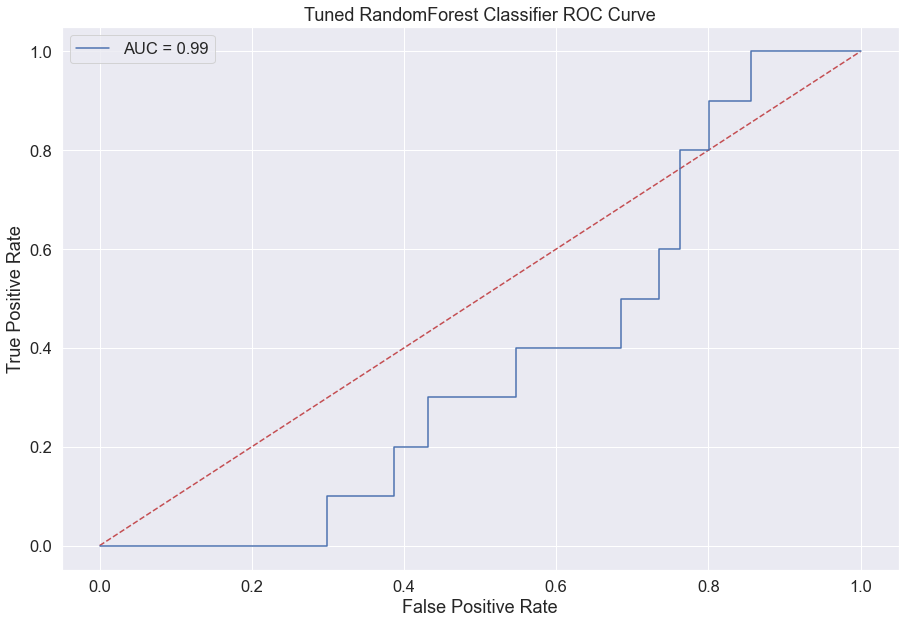

In [193]:
y_b_predict_prob = brf_cv.predict_proba(X_test)[:,1]

tuned_brf_roc_auc = roc_auc_score(y_b_test, y_b_predict_prob)
fpr, tpr, thresholds = roc_curve(y_b_test, y_b_predict_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tuned_rf_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned RandomForest Classifier ROC Curve')
plt.legend(loc=0)
plt.show()

## XGBoost

In [194]:
pipeline = Pipeline([('sm', sm), ('scaler', StandardScaler()), 
                     ('xgb', xgb)])

param_grid = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__max_depth': [3, 4, 5]
        }

bxgb_cv = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1)

bxgb_cv.fit(X_train, y_b_train)

print("Tuned XGBoost Parameters: {}".format(bxgb_cv.best_params_))
print("Tuned XGBoost Accuracy: {:.2f}%".format(bxgb_cv.best_score_*100))
print(classification_report(y_b_test, bxgb_cv.predict(X_test)))

Tuned XGBoost Parameters: {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 0.5, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.6}
Tuned XGBoost Accuracy: nan%
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       181
         1.0       0.00      0.00      0.00        10

    accuracy                           0.95       191
   macro avg       0.47      0.50      0.49       191
weighted avg       0.90      0.95      0.92       191



C:\Users\alexp\anaconda3\envs\dissclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Overview:
Serious flaws when replicating the procedure onto bubbles. Every single model failed. Potential coding problems. This could be due to very imbalanced train/test. Seems like no bubbles occur until the 80's and a lot occurred during test set timeframe...

Next steps:
- Investigate code. May have done something wrong.

- Investigate **overfitting**. This could explain the large amount of false positives in some models. Therefore, need to check time series cross validation. However, I did investigate using RandomUnderSampler instead of SMOTE and ran into the exact same issues.

- **Ensure transofmrations are correct** and potentially scale for all models.

# 5 - Classification (Stock Market Crashes) - INCOMPLETE

In [195]:
# Important to remove outliers (e.g., flash crashes?) - shouldn't be a problem as its end of month data

In [196]:
# Defining stock market crash and obtaining data:


# 6 - Combining Models

The aim is to essentially use the prediction of a bubble, recession, or stock market crash to be used as a variable to improve the predictions of another phenomenon. Whilst not transitive, bubbles often result in recessions, and recessions often cause stock market crashes. Is this doable simply by incorporating the predict_proba outcome for each from the best model, or are there more theoretically-sound methods to combining model outcomes and utilising them as explanatory variables?

# 7 - Predicting N-Periods

In [ ]:
# Creating extra lags to predict OOS whether a recession/bubble/crash is imminent over a given period of time.

# Additional Visualisations